Team Krøllebølle

Jakob Cetti Hansen (103353), Clara Hollenbeck (103326), Niklas Falke (105243)

# New notebook

We started over from scratch so we have an old notebook and a new notebook

## Setup

Requires Python 3.11 and Poetry 1.6. Run setup commands to begin:
```
!poetry install
!poetry run jupyter lab
```

Dependencies from pyproject.toml
```
python = "^3.11"
darts = "^0.26.0"
jupyter = "^1.0.0"
torch = "2.1.0"
tsfresh = "^0.20.1"
tqdm = "^4.66.1"
optuna = "^3.4.0"
prophet = "^1.1.5"
catboost = "^1.2.2"
lightgbm = "^4.1.0"
```

In [1]:
import os
import copy
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
display_plots = True

Load data

In [2]:
def get_raw_data():
    return {
        "A": {
            "test_est": pd.read_parquet(os.path.join("data", "A", "X_test_estimated.parquet")),
            "train_est": pd.read_parquet(os.path.join("data", "A", "X_train_estimated.parquet")),
            "train_obs": pd.read_parquet(os.path.join("data", "A", "X_train_observed.parquet")),
            "train_tar": pd.read_parquet(os.path.join("data", "A", "train_targets.parquet")),
        },
        "B": {
            "test_est": pd.read_parquet(os.path.join("data", "B", "X_test_estimated.parquet")),
            "train_est": pd.read_parquet(os.path.join("data", "B", "X_train_estimated.parquet")),
            "train_obs": pd.read_parquet(os.path.join("data", "B", "X_train_observed.parquet")),
            "train_tar": pd.read_parquet(os.path.join("data", "B", "train_targets.parquet")),
        },
        "C": {
            "test_est": pd.read_parquet(os.path.join("data", "C", "X_test_estimated.parquet")),
            "train_est": pd.read_parquet(os.path.join("data", "C", "X_train_estimated.parquet")),
            "train_obs": pd.read_parquet(os.path.join("data", "C", "X_train_observed.parquet")),
            "train_tar": pd.read_parquet(os.path.join("data", "C", "train_targets.parquet")),
        },
    }
data = get_raw_data()

View raw data

In [3]:
for loc in data:
    for type in data[loc]:
        display(loc, type, data[loc][type])

'A'

'test_est'

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0    2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1    2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2    2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3    2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4    2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   
...                  ...                 ...                       ...   
2875 2023-07-02 07:00:31 2023-07-03 22:45:00                       9.1   
2876 2023-07-02 07:00:31 2023-07-03 23:00:00                       9.1   
2877 2023-07-02 07:00:31 2023-07-03 23:15:00                       9.1   
2878 2023-07-02 07:00:31 2023-07-03 23:30:00                       9.0   
2879 2023-07-02 07:00:31 2023-07-03 23:45:00                       9.0   

      air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                   1.286            912.700012                    0.0   
1                   1.287            912.700012                    0.0   
2                   1.287            912.700012                    0.0   
3                   1.287            912.700012                    0.0   
4                   1.287                   NaN                    0.0   
...                   ...                   ...                    ...   
2875                1.207           2090.600098                    0.0   
2876                1.207           2015.800049                    0.0   
2877                1.208           2015.699951                    0.0   
2878                1.208           2015.599976                    0.0   
2879                1.208           2015.599976                    0.0   

      clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                 0.0       1041.199951              0.0      271.700012   
1                 0.0       1054.800049              0.0      271.700012   
2                 0.0       1068.300049              0.0      271.600006   
3                 0.0       1081.900024              0.0      271.600006   
4                 0.0       1095.400024              0.0      271.600006   
...               ...               ...              ...             ...   
2875              0.0       1629.400024              0.0      282.700012   
2876              0.0       1537.300049              0.0      282.700012   
2877              0.0       1471.400024              0.0      282.700012   
2878              0.0       1405.500000              0.0      282.700012   
2879              0.0       1339.599976              0.0      282.600006   

      diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0               0.0               0.0           0.0              0.0   
1               0.0               0.0           0.0              0.0   
2               0.0               0.0           0.0              0.0   
3               0.0               0.0           0.0              0.0   
4               0.0               0.0           0.0              0.0   
...             ...               ...           ...              ...   
2875            0.0               0.0           0.0              0.0   
2876            0.0               0.0           0.0              0.0   
2877            0.0               0.0           0.0              0.0   
2878            0.0               0.0           0.0              0.0   
2879            0.0               0.0           0.0              0.0   

      effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   80.699997          6.0                0.0   
1                   77.000000          6.0                0.0   
2                   73.099998          6.0                0.0   
3                   69.000000          6.0                0.0   
4                   64.500000          6.0                0.0   
...                       ...          ...                ...   
2875

'A'

'train_est'

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0     2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1     2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2     2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3     2022-10-27 07:00:18 2022-10-28 22:45:00                       8.3   
4     2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   
...                   ...                 ...                       ...   
17571 2023-04-29 07:00:05 2023-04-30 22:45:00                       4.5   
17572 2023-04-29 07:00:05 2023-04-30 23:00:00                       4.5   
17573 2023-04-29 07:00:05 2023-04-30 23:15:00                       4.5   
17574 2023-04-29 07:00:05 2023-04-30 23:30:00                       4.5   
17575 2023-04-29 07:00:05 2023-04-30 23:45:00                       4.5   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                    1.233           1425.099976                    0.0   
1                    1.233           2085.899902                    0.0   
2                    1.233           2746.600098                    0.0   
3                    1.233           3407.399902                    0.0   
4                    1.233           4068.199951                    0.0   
...                    ...                   ...                    ...   
17571                1.281           1173.900024                    0.0   
17572                1.281           1054.199951                    0.0   
17573                1.281           1435.800049                    0.0   
17574                1.281           1817.400024                    0.0   
17575                1.281           2198.899902                    0.0   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                  0.0       1211.699951              1.0      281.399994   
1                  0.0       1560.500000              1.0      281.299988   
2                  0.0       1909.400024              1.0      281.200012   
3                  0.0       2258.199951              1.0      281.200012   
4                  0.0       2607.000000              1.0      281.100006   
...                ...               ...              ...             ...   
17571              0.0        536.500000              0.0      272.299988   
17572              0.0        542.400024              0.0      272.200012   
17573              0.0        531.799988              0.0      272.299988   
17574              0.0        521.200012              0.0      272.299988   
17575              0.0        510.700012              0.0      272.299988   

       diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                0.0               0.0           0.0              0.0   
1                0.0               0.0           0.0              0.0   
2                0.0               0.0           0.0              0.0   
3                0.0               0.0           0.0              0.0   
4                0.0               0.0           0.0              0.0   
...              ...               ...           ...              ...   
17571            0.0               0.0           0.0              0.0   
17572            0.0               0.0           0.0              0.0   
17573            0.0               0.0           0.0              0.0   
17574            0.0               0.0           0.0              0.0   
17575            0.0               0.0           0.0              0.0   

       effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   100.000000          6.0                0.0   
1                   100.000000          6.0                0.0   
2                   100.000000          6.0                0.0   
3                   100.000000          6.0                0.0   
4                   100.000000          6.0                0.0   
...             

'A'

'train_obs'

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0      2019-06-02 22:00:00                       7.7                1.230   
1      2019-06-02 22:15:00                       7.7                1.229   
2      2019-06-02 22:30:00                       7.7                1.228   
3      2019-06-02 22:45:00                       7.7                1.226   
4      2019-06-02 23:00:00                       7.7                1.225   
...                    ...                       ...                  ...   
118664 2022-10-21 00:00:00                       5.0                1.292   
118665 2022-10-21 00:15:00                       5.0                1.292   
118666 2022-10-21 00:30:00                       5.0                1.292   
118667 2022-10-21 00:45:00                       5.0                1.292   
118668 2022-10-21 01:00:00                       5.0                1.292   

        ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0                1744.900024                    0.0              0.0   
1                1734.000000                    0.0              0.0   
2                1723.500000                    0.0              0.0   
3                1713.400024                    0.0              0.0   
4                1703.599976                    0.0              0.0   
...                      ...                    ...              ...   
118664                   NaN                    0.0              0.0   
118665                   NaN                    0.0              0.0   
118666                   NaN                    0.0              0.0   
118667                   NaN                    0.0              0.0   
118668                   NaN                    0.0              0.0   

        cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0            1744.900024              0.0      280.299988            0.0   
1            1734.000000              0.0      280.299988            0.0   
2            1723.500000              0.0      280.299988            0.0   
3            1713.400024              0.0      280.299988            0.0   
4            1703.599976              0.0      280.299988            0.0   
...                  ...              ...             ...            ...   
118664               NaN              0.0      273.700012            0.0   
118665               NaN              0.0      273.700012            0.0   
118666               NaN              0.0      273.700012            0.0   
118667               NaN              0.0      273.600006            0.0   
118668               NaN              0.0      273.600006            0.0   

        diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                    0.0           0.0              0.0   
1                    0.0           0.0              0.0   
2                    0.0           0.0              0.0   
3                    0.0           0.0              0.0   
4                    0.0           0.0              0.0   
...                  ...           ...              ...   
118664               0.0           0.0              0.0   
118665               0.0           0.0              0.0   
118666               0.0           0.0              0.0   
118667               0.0           0.0              0.0   
118668               0.0           0.0              0.0   

        effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                     98.699997          6.0                0.0   
1                     99.000000          6.0                0.0   
2                     99.199997          6.0                0.0   
3                     99.400002          6.0                0.0   
4                     99.599998          6.0                0.0   
...                         ...          ...                ...   
118664                 2.800000          6.0                0.0   
118665                 2.300000          6.0                0.0  

'A'

'train_tar'

time  pv_measurement
0     2019-06-02 22:00:00            0.00
1     2019-06-02 23:00:00            0.00
2     2019-06-03 00:00:00            0.00
3     2019-06-03 01:00:00            0.00
4     2019-06-03 02:00:00           19.36
...                   ...             ...
34080 2023-04-30 19:00:00            9.02
34081 2023-04-30 20:00:00            0.00
34082 2023-04-30 21:00:00            0.00
34083 2023-04-30 22:00:00            0.00
34084 2023-04-30 23:00:00            0.00

[34085 rows x 2 columns]

'B'

'test_est'

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0    2023-04-30 07:00:04 2023-05-01 00:00:00                       4.3   
1    2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2    2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3    2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4    2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   
...                  ...                 ...                       ...   
2875 2023-07-02 07:00:31 2023-07-03 22:45:00                       9.0   
2876 2023-07-02 07:00:31 2023-07-03 23:00:00                       9.1   
2877 2023-07-02 07:00:31 2023-07-03 23:15:00                       9.0   
2878 2023-07-02 07:00:31 2023-07-03 23:30:00                       9.0   
2879 2023-07-02 07:00:31 2023-07-03 23:45:00                       9.0   

      air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                   1.283            912.299988                    0.0   
1                   1.283            912.299988                    0.0   
2                   1.283            912.299988                    0.0   
3                   1.283            912.299988                    0.0   
4                   1.283                   NaN                    0.0   
...                   ...                   ...                    ...   
2875                1.206           2091.000000                    0.0   
2876                1.207           2015.300049                    0.0   
2877                1.207           2015.199951                    0.0   
2878                1.207           2015.000000                    0.0   
2879                1.207           2014.900024                    0.0   

      clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                 0.0       1039.900024              0.0      271.700012   
1                 0.0       1053.099976              0.0      271.700012   
2                 0.0       1066.400024              0.0      271.600006   
3                 0.0       1079.599976              0.0      271.600006   
4                 0.0       1092.900024              0.0      271.600006   
...               ...               ...              ...             ...   
2875              0.0       1630.500000              0.0      282.700012   
2876              0.0       1538.599976              0.0      282.700012   
2877              0.0       1473.599976              0.0      282.700012   
2878              0.0       1408.599976              0.0      282.700012   
2879              0.0       1343.599976              0.0      282.600006   

      diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0               0.0               0.0           0.0              0.0   
1               0.0               0.0           0.0              0.0   
2               0.0               0.0           0.0              0.0   
3               0.0               0.0           0.0              0.0   
4               0.0               0.0           0.0              0.0   
...             ...               ...           ...              ...   
2875            0.0               0.0           0.0              0.0   
2876            0.0               0.0           0.0              0.0   
2877            0.0               0.0           0.0              0.0   
2878            0.0               0.0           0.0              0.0   
2879            0.0               0.0           0.0              0.0   

      effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   80.699997          7.0                0.0   
1                   77.099998          7.0                0.0   
2                   73.199997          7.0                0.0   
3                   69.000000          7.0                0.0   
4                   64.599998          7.0                0.0   
...                       ...          ...                ...   
2875

'B'

'train_est'

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0     2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1     2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2     2022-10-27 07:00:18 2022-10-28 22:30:00                       8.4   
3     2022-10-27 07:00:18 2022-10-28 22:45:00                       8.4   
4     2022-10-27 07:00:18 2022-10-28 23:00:00                       8.5   
...                   ...                 ...                       ...   
17571 2023-04-29 07:00:05 2023-04-30 22:45:00                       4.5   
17572 2023-04-29 07:00:05 2023-04-30 23:00:00                       4.5   
17573 2023-04-29 07:00:05 2023-04-30 23:15:00                       4.5   
17574 2023-04-29 07:00:05 2023-04-30 23:30:00                       4.5   
17575 2023-04-29 07:00:05 2023-04-30 23:45:00                       4.5   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                    1.233           1425.099976                    0.0   
1                    1.233           2086.000000                    0.0   
2                    1.232           2746.899902                    0.0   
3                    1.232           3407.800049                    0.0   
4                    1.231           4068.699951                    0.0   
...                    ...                   ...                    ...   
17571                1.280           1175.400024                    0.0   
17572                1.281           1055.800049                    0.0   
17573                1.280           1437.300049                    0.0   
17574                1.280           1818.699951                    0.0   
17575                1.280           2200.100098                    0.0   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                  0.0       1211.900024              1.0      281.399994   
1                  0.0       1562.500000              1.0      281.399994   
2                  0.0       1913.099976              1.0      281.500000   
3                  0.0       2263.699951              1.0      281.500000   
4                  0.0       2614.300049              1.0      281.500000   
...                ...               ...              ...             ...   
17571              0.0        536.299988              0.0      272.200012   
17572              0.0        542.099976              0.0      272.200012   
17573              0.0        531.500000              0.0      272.200012   
17574              0.0        520.900024              0.0      272.299988   
17575              0.0        510.299988              0.0      272.299988   

       diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                0.0               0.0           0.0              0.0   
1                0.0               0.0           0.0              0.0   
2                0.0               0.0           0.0              0.0   
3                0.0               0.0           0.0              0.0   
4                0.0               0.0           0.0              0.0   
...              ...               ...           ...              ...   
17571            0.0               0.0           0.0              0.0   
17572            0.0               0.0           0.0              0.0   
17573            0.0               0.0           0.0              0.0   
17574            0.0               0.0           0.0              0.0   
17575            0.0               0.0           0.0              0.0   

       effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   100.000000          7.0                0.0   
1                   100.000000          7.0                0.0   
2                   100.000000          7.0                0.0   
3                   100.000000          7.0                0.0   
4                   100.000000          7.0                0.0   
...             

'B'

'train_obs'

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0      2019-01-01 00:00:00                       5.6                1.239   
1      2019-01-01 00:15:00                       5.6                1.239   
2      2019-01-01 00:30:00                       5.5                1.240   
3      2019-01-01 00:45:00                       5.4                1.241   
4      2019-01-01 01:00:00                       5.4                1.241   
...                    ...                       ...                  ...   
116924 2022-05-02 23:00:00                       4.3                1.282   
116925 2022-05-02 23:15:00                       4.3                1.282   
116926 2022-05-02 23:30:00                       4.3                1.282   
116927 2022-05-02 23:45:00                       4.2                1.283   
116928 2022-05-03 00:00:00                       4.2                1.283   

        ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0                1226.400024                    0.0              0.0   
1                1209.300049                    0.0              0.0   
2                1192.099976                    0.0              0.0   
3                1174.900024                    0.0              0.0   
4                1157.599976                    0.0              0.0   
...                      ...                    ...              ...   
116924                   NaN                    0.0              0.0   
116925                   NaN                    0.0              0.0   
116926                   NaN                    0.0              0.0   
116927                   NaN                    0.0              0.0   
116928                   NaN                    0.0              0.0   

        cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0            1226.400024              0.0      275.399994            0.0   
1            1209.300049              0.0      275.200012            0.0   
2            1192.099976              0.0      275.100006            0.0   
3            1174.900024              0.0      274.899994            0.0   
4            1157.599976              0.0      274.700012            0.0   
...                  ...              ...             ...            ...   
116924        691.599976              0.0      271.500000            0.0   
116925        689.000000              0.0      271.500000            0.0   
116926        686.400024              0.0      271.500000            0.0   
116927        683.799988              0.0      271.399994            0.0   
116928        681.200012              0.0      271.399994            0.0   

        diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                    0.0           0.0              0.0   
1                    0.0           0.0              0.0   
2                    0.0           0.0              0.0   
3                    0.0           0.0              0.0   
4                    0.0           0.0              0.0   
...                  ...           ...              ...   
116924               0.0           0.0              0.0   
116925               0.0           0.0              0.0   
116926               0.0           0.0              0.0   
116927               0.0           0.0              0.0   
116928               0.0           0.0              0.0   

        effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                     69.599998          7.0                0.0   
1                     78.599998          7.0                0.0   
2                     86.300003          7.0                0.0   
3                     92.800003          7.0                0.0   
4                     98.099998          7.0                0.0   
...                         ...          ...                ...   
116924                46.900002          7.0                0.0   
116925                48.200001          7.0                0.0  

'B'

'train_tar'

time  pv_measurement
0     2018-12-31 23:00:00        0.000000
1     2019-01-01 00:00:00        0.000000
2     2019-01-01 01:00:00        0.000000
3     2019-01-01 02:00:00        0.000000
4     2019-01-01 03:00:00        0.000000
...                   ...             ...
32843 2023-04-30 19:00:00        0.828587
32844 2023-04-30 20:00:00       -0.000000
32845 2023-04-30 21:00:00       -0.000000
32846 2023-04-30 22:00:00       -0.000000
32847 2023-04-30 23:00:00       -0.000000

[32848 rows x 2 columns]

'C'

'test_est'

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0    2023-04-30 07:00:04 2023-05-01 00:00:00                       4.2   
1    2023-04-30 07:00:04 2023-05-01 00:15:00                       4.2   
2    2023-04-30 07:00:04 2023-05-01 00:30:00                       4.1   
3    2023-04-30 07:00:04 2023-05-01 00:45:00                       4.1   
4    2023-04-30 07:00:04 2023-05-01 01:00:00                       4.1   
...                  ...                 ...                       ...   
2875 2023-07-02 07:00:31 2023-07-03 22:45:00                       9.0   
2876 2023-07-02 07:00:31 2023-07-03 23:00:00                       9.0   
2877 2023-07-02 07:00:31 2023-07-03 23:15:00                       9.0   
2878 2023-07-02 07:00:31 2023-07-03 23:30:00                       8.9   
2879 2023-07-02 07:00:31 2023-07-03 23:45:00                       8.9   

      air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                   1.286                   NaN                    0.0   
1                   1.286                   NaN                    0.0   
2                   1.286                   NaN                    0.0   
3                   1.286                   NaN                    0.0   
4                   1.286                   NaN                    0.0   
...                   ...                   ...                    ...   
2875                1.207           2003.500000                    0.0   
2876                1.207           2005.599976                    0.0   
2877                1.207           2005.500000                    0.0   
2878                1.207           2005.500000                    0.0   
2879                1.207           2005.500000                    0.0   

      clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                 0.0       1178.000000              0.0      271.100006   
1                 0.0       1217.000000              0.0      271.100006   
2                 0.0       1256.000000              0.0      271.000000   
3                 0.0       1295.000000              0.0      270.899994   
4                 0.0       1334.099976              0.0      270.899994   
...               ...               ...              ...             ...   
2875              0.0       1573.000000              0.0      282.600006   
2876              0.0       1471.000000              0.0      282.500000   
2877              0.0       1346.900024              0.0      282.500000   
2878              0.0       1222.800049              0.0      282.500000   
2879              0.0       1098.699951              0.0      282.399994   

      diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0               0.0               0.0           0.0              0.0   
1               0.0               0.0           0.0              0.0   
2               0.0               0.0           0.0              0.0   
3               0.0               0.0           0.0              0.0   
4               0.0               0.0           0.0              0.0   
...             ...               ...           ...              ...   
2875            0.0               0.0           0.0              0.0   
2876            0.0               0.0           0.0              0.0   
2877            0.0               0.0           0.0              0.0   
2878            0.0               0.0           0.0              0.0   
2879            0.0               0.0           0.0              0.0   

      effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   73.699997         24.0                0.0   
1                   70.800003         24.0                0.0   
2                   67.900002         24.0                0.0   
3                   64.800003         24.0                0.0   
4                   61.599998         24.0                0.0   
...                       ...          ...                ...   
2875

'C'

'train_est'

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0     2022-10-27 07:00:18 2022-10-28 22:00:00                       8.3   
1     2022-10-27 07:00:18 2022-10-28 22:15:00                       8.3   
2     2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3     2022-10-27 07:00:18 2022-10-28 22:45:00                       8.2   
4     2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   
...                   ...                 ...                       ...   
17571 2023-04-29 07:00:05 2023-04-30 22:45:00                       4.4   
17572 2023-04-29 07:00:05 2023-04-30 23:00:00                       4.4   
17573 2023-04-29 07:00:05 2023-04-30 23:15:00                       4.4   
17574 2023-04-29 07:00:05 2023-04-30 23:30:00                       4.4   
17575 2023-04-29 07:00:05 2023-04-30 23:45:00                       4.4   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                    1.231           1427.400024                    0.0   
1                    1.231           2089.000000                    0.0   
2                    1.231           2750.500000                    0.0   
3                    1.230           3412.100098                    0.0   
4                    1.230           4073.699951                    0.0   
...                    ...                   ...                    ...   
17571                1.280           1034.599976                    0.0   
17572                1.280            897.200012                    0.0   
17573                1.280           1288.699951                    0.0   
17574                1.280           1680.300049                    0.0   
17575                1.279           2071.800049                    0.0   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                  0.0       1215.800049              1.0      281.200012   
1                  0.0       1425.900024              1.0      281.200012   
2                  0.0       1636.099976              1.0      281.100006   
3                  0.0       1846.199951              1.0      281.100006   
4                  0.0       2056.399902              1.0      281.100006   
...                ...               ...              ...             ...   
17571              0.0        562.299988              0.0      272.000000   
17572              0.0        569.500000              0.0      272.000000   
17573              0.0        562.299988              0.0      272.000000   
17574              0.0        555.099976              0.0      271.899994   
17575              0.0        547.799988              0.0      271.899994   

       diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                0.0               0.0           0.0              0.0   
1                0.0               0.0           0.0              0.0   
2                0.0               0.0           0.0              0.0   
3                0.0               0.0           0.0              0.0   
4                0.0               0.0           0.0              0.0   
...              ...               ...           ...              ...   
17571            0.0               0.0           0.0              0.0   
17572            0.0               0.0           0.0              0.0   
17573            0.0               0.0           0.0              0.0   
17574            0.0               0.0           0.0              0.0   
17575            0.0               0.0           0.0              0.0   

       effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   100.000000         24.0                0.0   
1                   100.000000         24.0                0.0   
2                   100.000000         24.0                0.0   
3                   100.000000         24.0                0.0   
4                   100.000000         24.0                0.0   
...             

'C'

'train_obs'

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0      2019-01-01 00:00:00                       5.6                1.240   
1      2019-01-01 00:15:00                       5.5                1.241   
2      2019-01-01 00:30:00                       5.4                1.241   
3      2019-01-01 00:45:00                       5.4                1.241   
4      2019-01-01 01:00:00                       5.3                1.241   
...                    ...                       ...                  ...   
116820 2022-05-01 21:00:00                       4.9                1.257   
116821 2022-05-01 21:15:00                       4.9                1.256   
116822 2022-05-01 21:30:00                       4.9                1.256   
116823 2022-05-01 21:45:00                       4.8                1.255   
116824 2022-05-01 22:00:00                       4.8                1.255   

        ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0                1153.599976                    0.0              0.0   
1                1137.900024                    0.0              0.0   
2                1122.199951                    0.0              0.0   
3                1106.400024                    0.0              0.0   
4                1090.599976                    0.0              0.0   
...                      ...                    ...              ...   
116820           2652.000000                    0.0              0.0   
116821           2375.300049                    0.0              0.0   
116822           2098.699951                    0.0              0.0   
116823           1822.000000                    0.0              0.0   
116824           1545.300049                    0.0              0.0   

        cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0            1153.599976              1.0      275.200012            0.0   
1            1137.900024              1.0      275.100006            0.0   
2            1122.199951              1.0      274.899994            0.0   
3            1106.400024              1.0      274.700012            0.0   
4            1090.599976              1.0      274.500000            0.0   
...                  ...              ...             ...            ...   
116820       1536.500000              0.0      273.600006            0.0   
116821       1484.500000              0.0      273.600006            0.0   
116822       1432.500000              0.0      273.500000            0.0   
116823       1380.400024              0.0      273.399994            0.0   
116824       1328.400024              0.0      273.399994            0.0   

        diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                    0.0           0.0              0.0   
1                    0.0           0.0              0.0   
2                    0.0           0.0              0.0   
3                    0.0           0.0              0.0   
4                    0.0           0.0              0.0   
...                  ...           ...              ...   
116820               0.0           0.0              0.0   
116821               0.0           0.0              0.0   
116822               0.0           0.0              0.0   
116823               0.0           0.0              0.0   
116824               0.0           0.0              0.0   

        effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                     63.599998         24.0                0.0   
1                     74.900002         24.0                0.0   
2                     84.300003         24.0                0.0   
3                     92.000000         24.0                0.0   
4                     98.000000         24.0                0.0   
...                         ...          ...                ...   
116820                95.000000         24.0                0.0   
116821                97.000000         24.0                0.0  

'C'

'train_tar'

time  pv_measurement
0     2018-12-31 23:00:00             NaN
1     2019-01-01 00:00:00             NaN
2     2019-01-01 01:00:00             NaN
3     2019-01-01 02:00:00             NaN
4     2019-01-01 03:00:00             NaN
...                   ...             ...
32150 2023-04-30 19:00:00           50.96
32151 2023-04-30 20:00:00            2.94
32152 2023-04-30 21:00:00            0.00
32153 2023-04-30 22:00:00           -0.00
32154 2023-04-30 23:00:00           -0.00

[32155 rows x 2 columns]

Find the number of unique values for each type

In [4]:
pd.concat([data[loc][type] for loc in data for type in data[loc]]).nunique()

date_calc                            214
date_forecast                     153805
absolute_humidity_2m:gm3             183
air_density_2m:kgm3                  301
ceiling_height_agl:m               78367
clear_sky_energy_1h:J             217030
clear_sky_rad:W                     8371
cloud_base_agl:m                   61031
dew_or_rime:idx                        3
dew_point_2m:K                       473
diffuse_rad:W                       3204
diffuse_rad_1h:J                  215787
direct_rad:W                        6590
direct_rad_1h:J                   180598
effective_cloud_cover:p             1001
elevation:m                            3
fresh_snow_12h:cm                    184
fresh_snow_1h:cm                      58
fresh_snow_24h:cm                    205
fresh_snow_3h:cm                     104
fresh_snow_6h:cm                     145
is_day:idx                             2
is_in_shadow:idx                       2
msl_pressure:hPa                     981
precip_5min:mm  

Plot target value

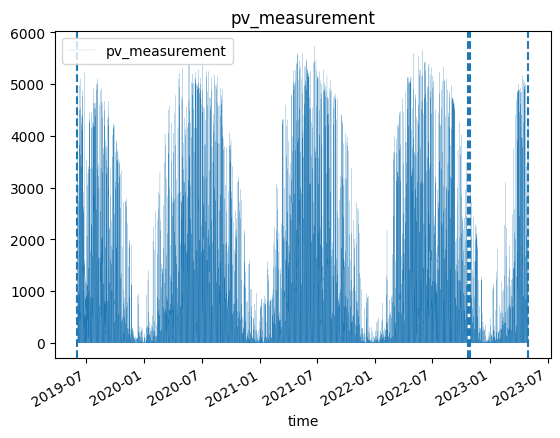

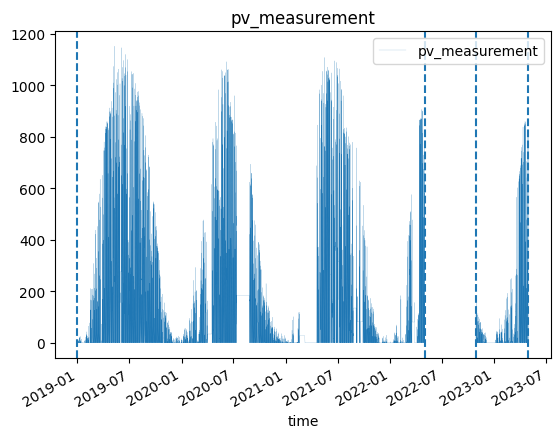

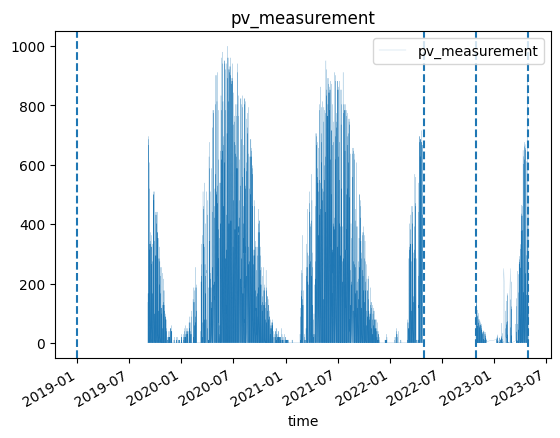

In [5]:
if display_plots:
    for loc in data:
        obs_start = data[loc]["train_obs"]["date_forecast"].min()
        obs_end = data[loc]["train_obs"]["date_forecast"].max()
        est_start = data[loc]["train_est"]["date_forecast"].min()
        est_end = data[loc]["train_est"]["date_forecast"].max()
        
        ax = data[loc]["train_tar"].set_index("time").plot(lw=0.1)
        ax.axvline(obs_start, linestyle='--')
        ax.axvline(obs_end, linestyle='--')
        ax.axvline(est_start, linestyle='--')
        ax.axvline(est_end, linestyle='--')
        ax.set_title("pv_measurement")
        plt.show()

## Transform data

Transform the raw data to be on the X y form

In [6]:
def transform_data(data):
    # Create empty list of location train data and location test data
    Xs = {"og" : {loc : {} for loc in data}}
    ys = {"og" : {loc : {} for loc in data}}
    
    for loc in data:
        # Copy data
        data_obs = data[loc]["train_obs"].copy()
        data_est = data[loc]["train_est"].copy()
        data_test = data[loc]["test_est"].copy()
        data_tar = data[loc]["train_tar"].copy()
        
        # Add a column with the difference between date_forecast and date_calc in seconds and 
        data_obs["forecast_seconds"] = np.zeros(data_obs.shape[0], dtype=np.float32)
        data_est["forecast_seconds"] = (data_est["date_forecast"] - data_est["date_calc"]).apply(lambda x: x.total_seconds()).astype('float32')
        data_test["forecast_seconds"] = (data_test["date_forecast"] - data_test["date_calc"]).apply(lambda x: x.total_seconds()).astype('float32')
        
        # Remove unneeded columns
        del data_est["date_calc"]
        del data_test["date_calc"]
        del data_obs["snow_density:kgm3"]
        del data_est["snow_density:kgm3"]
        del data_test["snow_density:kgm3"]

        # Find start and end date for obvsersed and estimated data
        obs_end = data_obs["date_forecast"].max()
        est_start = data_est["date_forecast"].min()
        treshold_date = obs_end + (est_start - obs_end) / 2
        
        # Outer join target data with estimated and observed data
        Xy_obs = pd.merge(
            data_tar[data_tar["time"] <= treshold_date],
            data_obs.rename(columns={"date_forecast": "time"}),
            on="time",
            how="outer"
        ).set_index("time").sort_index()
        Xy_est = pd.merge(
            data_tar[data_tar["time"] > treshold_date],
            data_est.rename(columns={"date_forecast": "time"}),
            on="time",
            how="outer"
        ).set_index("time").sort_index()

        # Assign Xs
        Xs["og"][loc]["obs"] = Xy_obs.drop("pv_measurement", axis=1)
        Xs["og"][loc]["est"] = Xy_est.drop("pv_measurement", axis=1)
        Xs["og"][loc]["test"] = data_test.rename(columns={"date_forecast": "time"}).set_index("time").sort_index()

        # Assign ys
        ys["og"][loc]["obs"] = Xy_obs["pv_measurement"]
        ys["og"][loc]["est"] = Xy_est["pv_measurement"]
        
    return Xs, ys

Xs, ys = transform_data(data)

Check that they have the same columns

In [7]:
def has_same_columns(df_lst):
    return all(set(df.columns) == set(df_lst[0].columns) for df in df_lst)

def are_all_equal(lst):
    return all(x == lst[0] for x in lst)

Xs_cols = Xs["og"]["A"]["obs"].columns.copy()
ys_col = ys["og"]["A"]["obs"].name
display(Xs["og"]["A"]["obs"].dtypes)

assert has_same_columns([Xs["og"][loc][type] for loc in Xs["og"] for type in Xs["og"][loc]]) 
assert are_all_equal([ys["og"][loc][type].name for loc in ys["og"] for type in ys["og"][loc]])

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
elevation:m                       float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_day:idx                        float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              

See stats about the data

In [8]:
pd.concat([Xs["og"][loc][type] for loc in Xs["og"] for type in Xs["og"][loc]]).describe()

absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count             413791.000000        413791.000000         338248.000000   
mean                   6.022480             1.255468           2796.203857   
std                    2.767936             0.037358           2488.790527   
min                    0.500000             1.139000             27.600000   
25%                    4.000000             1.230000           1048.199951   
50%                    5.400000             1.255000           1821.800049   
75%                    7.900000             1.279000           3795.424805   
max                   18.900000             1.441000          12431.299805   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           4.137910e+05    413791.000000     381929.000000   
mean            5.340971e+05       148.360306       1717.518188   
std             8.383486e+05       233.465897       1775.247437   
min             0.000000e+00         0.000000         27.299999   
25%             0.000000e+00         0.000000        596.700012   
50%             9.416100e+03         0.000000       1158.300049   
75%             8.397916e+05       233.699997       2067.500000   
max             3.007722e+06       837.000000      11688.900391   

       dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
count    413791.000000   413791.000000  413791.000000      4.137910e+05   
mean          0.002364      275.193665      40.693062      1.464950e+05   
std           0.253579        7.009235      61.931904      2.201175e+05   
min          -1.000000      247.300003       0.000000      0.000000e+00   
25%           0.000000      270.600006       0.000000      0.000000e+00   
50%           0.000000      275.000000       0.000000      1.198950e+04   
75%           0.000000      280.600006      68.300003      2.453228e+05   
max           1.000000      295.100006     345.700012      1.217465e+06   

        direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p    elevation:m  \
count  413791.000000     4.137910e+05            413791.000000  413791.000000   
mean       51.762341     1.863446e+05                67.066154      12.303769   
std       115.628448     4.105117e+05                34.583103       8.251439   
min         0.000000     0.000000e+00                 0.000000       6.000000   
25%         0.000000     0.000000e+00                41.599998       6.000000   
50%         0.000000     0.000000e+00                80.400002       7.000000   
75%        30.500000     1.181203e+05                98.900002      24.000000   
max       689.799988     2.451235e+06               100.000000      24.000000   

       fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
count      413791.000000     413791.000000      413791.000000   
mean            0.139911          0.011645           0.276628   
std             0.842233          0.118890           1.340529   
min             0.000000          0.000000           0.000000   
25%             0.000000          0.000000           0.000000   
50%             0.000000          0.000000           0.000000   
75%             0.000000          0.000000           0.000000   
max            37.599998          7.700000          37.599998   

       fresh_snow_3h:cm  fresh_snow_6h:cm     is_day:idx  is_in_shadow:idx  \
count     413791.000000     413791.000000  413791.000000     413791.000000   
mean           0.035001          0.069955       0.490383          0.559183   
std            0.297705          0.511651       0.499908          0.496486   
min            0.000000          0.000000       0.000000          0.000000   
25%            0.000000          0.000000       0.000000          0.000000   
50%            0.000000          0.000000       0.000000          1.000000   
75%            0.000000          0.000000       1.000000          1.000000   
max           20.799999         34.099998       1.000000          1.000000   

     

Plot timeperiod of test dates

time
0 days 00:15:00    2862
1 days 00:15:00      10
3 days 00:15:00       3
2 days 00:15:00       2
4 days 00:15:00       1
7 days 00:15:00       1
Name: count, dtype: int64

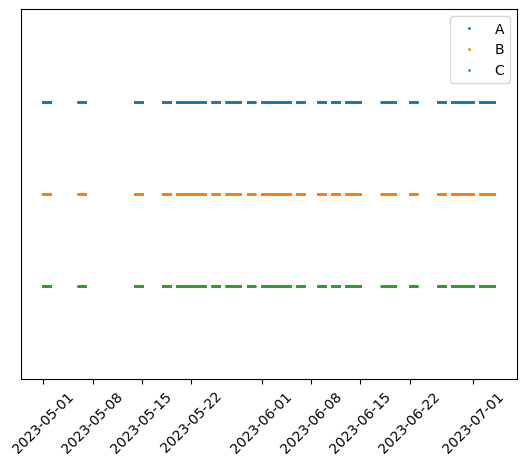

In [9]:
extract_dates = {loc: Xs["og"][loc]["test"].index.copy() for loc in Xs["og"]}

if display_plots:
    for height, loc in zip([3,2,1], extract_dates):
        plt.plot(extract_dates[loc], [height] * len(extract_dates[loc]), marker='o', markersize=1, linestyle='')
        
    display(extract_dates[loc].to_series().diff().value_counts())

    plt.gca().axes.get_yaxis().set_visible(False)    
    plt.ylim(0, 4)
    plt.legend([loc for loc in extract_dates])
    plt.xticks(rotation=45)
    plt.show()

def are_all_equal_series(series_lst):
    return all((series == series_lst[0]).all() for series in series_lst)

assert are_all_equal_series([extract_dates[loc] for loc in extract_dates])
extract_dates = extract_dates["A"]

Display ys

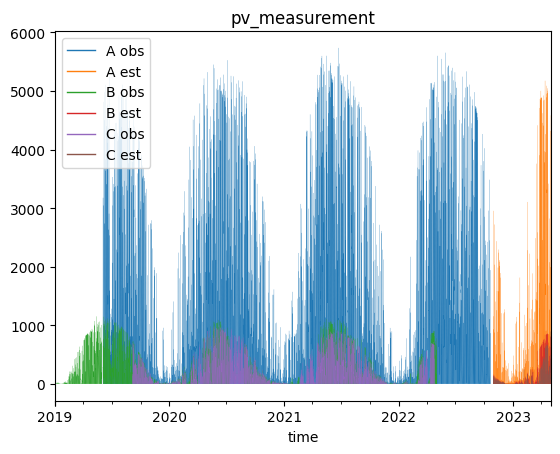

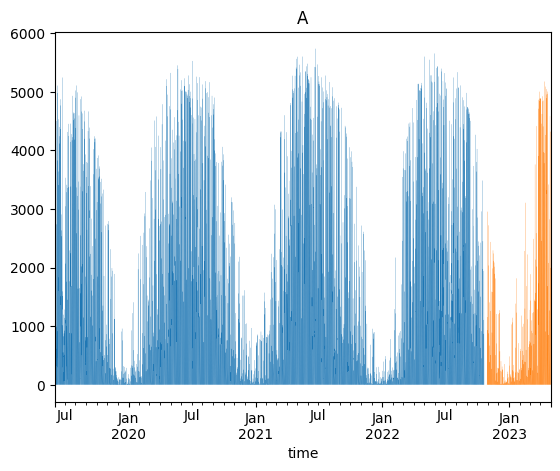

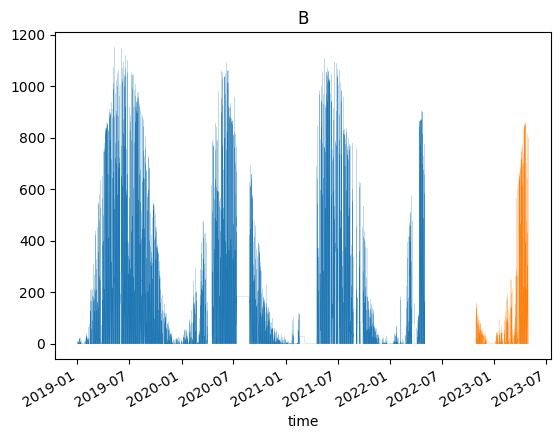

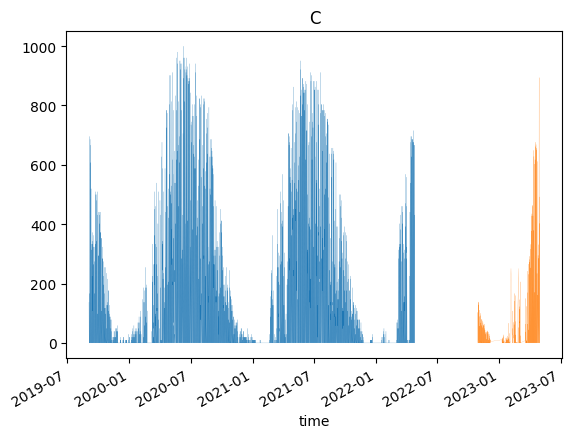

In [10]:
if display_plots:
    for loc in ys["og"]:
        for type in ys["og"][loc]:
            ax = ys["og"][loc][type].dropna().plot(lw=0.1)
    
    ax.set_title(ys_col)
    legend = ax.legend([loc + " " + type for loc in ys["og"] for type in ys["og"][loc]])
    for line in legend.get_lines():
        line.set_linewidth(1)
    plt.show()
    
    for loc in ys["og"]:
        for type in ys["og"][loc]:
            ax = ys["og"][loc][type].dropna().plot(lw=0.1)
    
        ax.set_title(loc)
        plt.show()

Display Xs only with nan values

Index(['ceiling_height_agl:m', 'cloud_base_agl:m'], dtype='object')

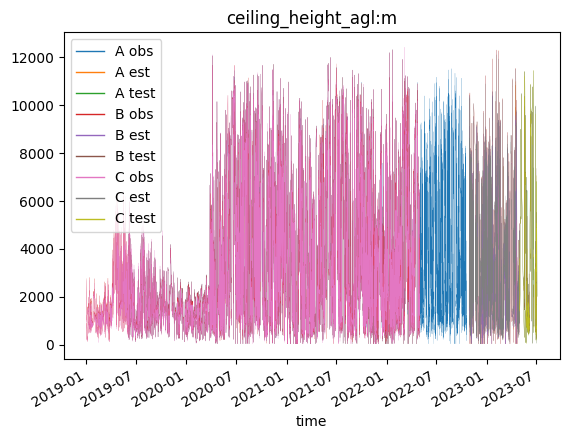

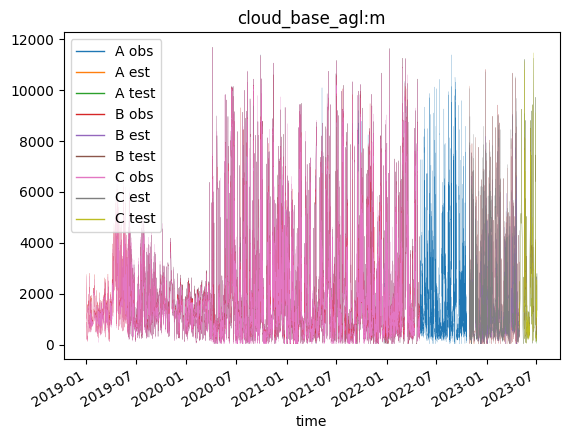

In [11]:
Xs_cols_with_nan = Xs_cols[pd.concat([Xs["og"][loc][type].dropna(how='all') for loc in Xs["og"] for type in Xs["og"][loc]]).isna().any()]
display(Xs_cols_with_nan)

if display_plots:
    for col in Xs_cols_with_nan:
        for loc in Xs["og"]:
            for type in Xs["og"][loc]:
                ax = Xs["og"][loc][type][col].dropna().plot(lw=0.1)
    
        ax.set_title(col)
        legend = ax.legend([loc + " " + type for loc in Xs["og"] for type in Xs["og"][loc]])
        for line in legend.get_lines():
            line.set_linewidth(1)
        plt.show()

Plot histogram of the data

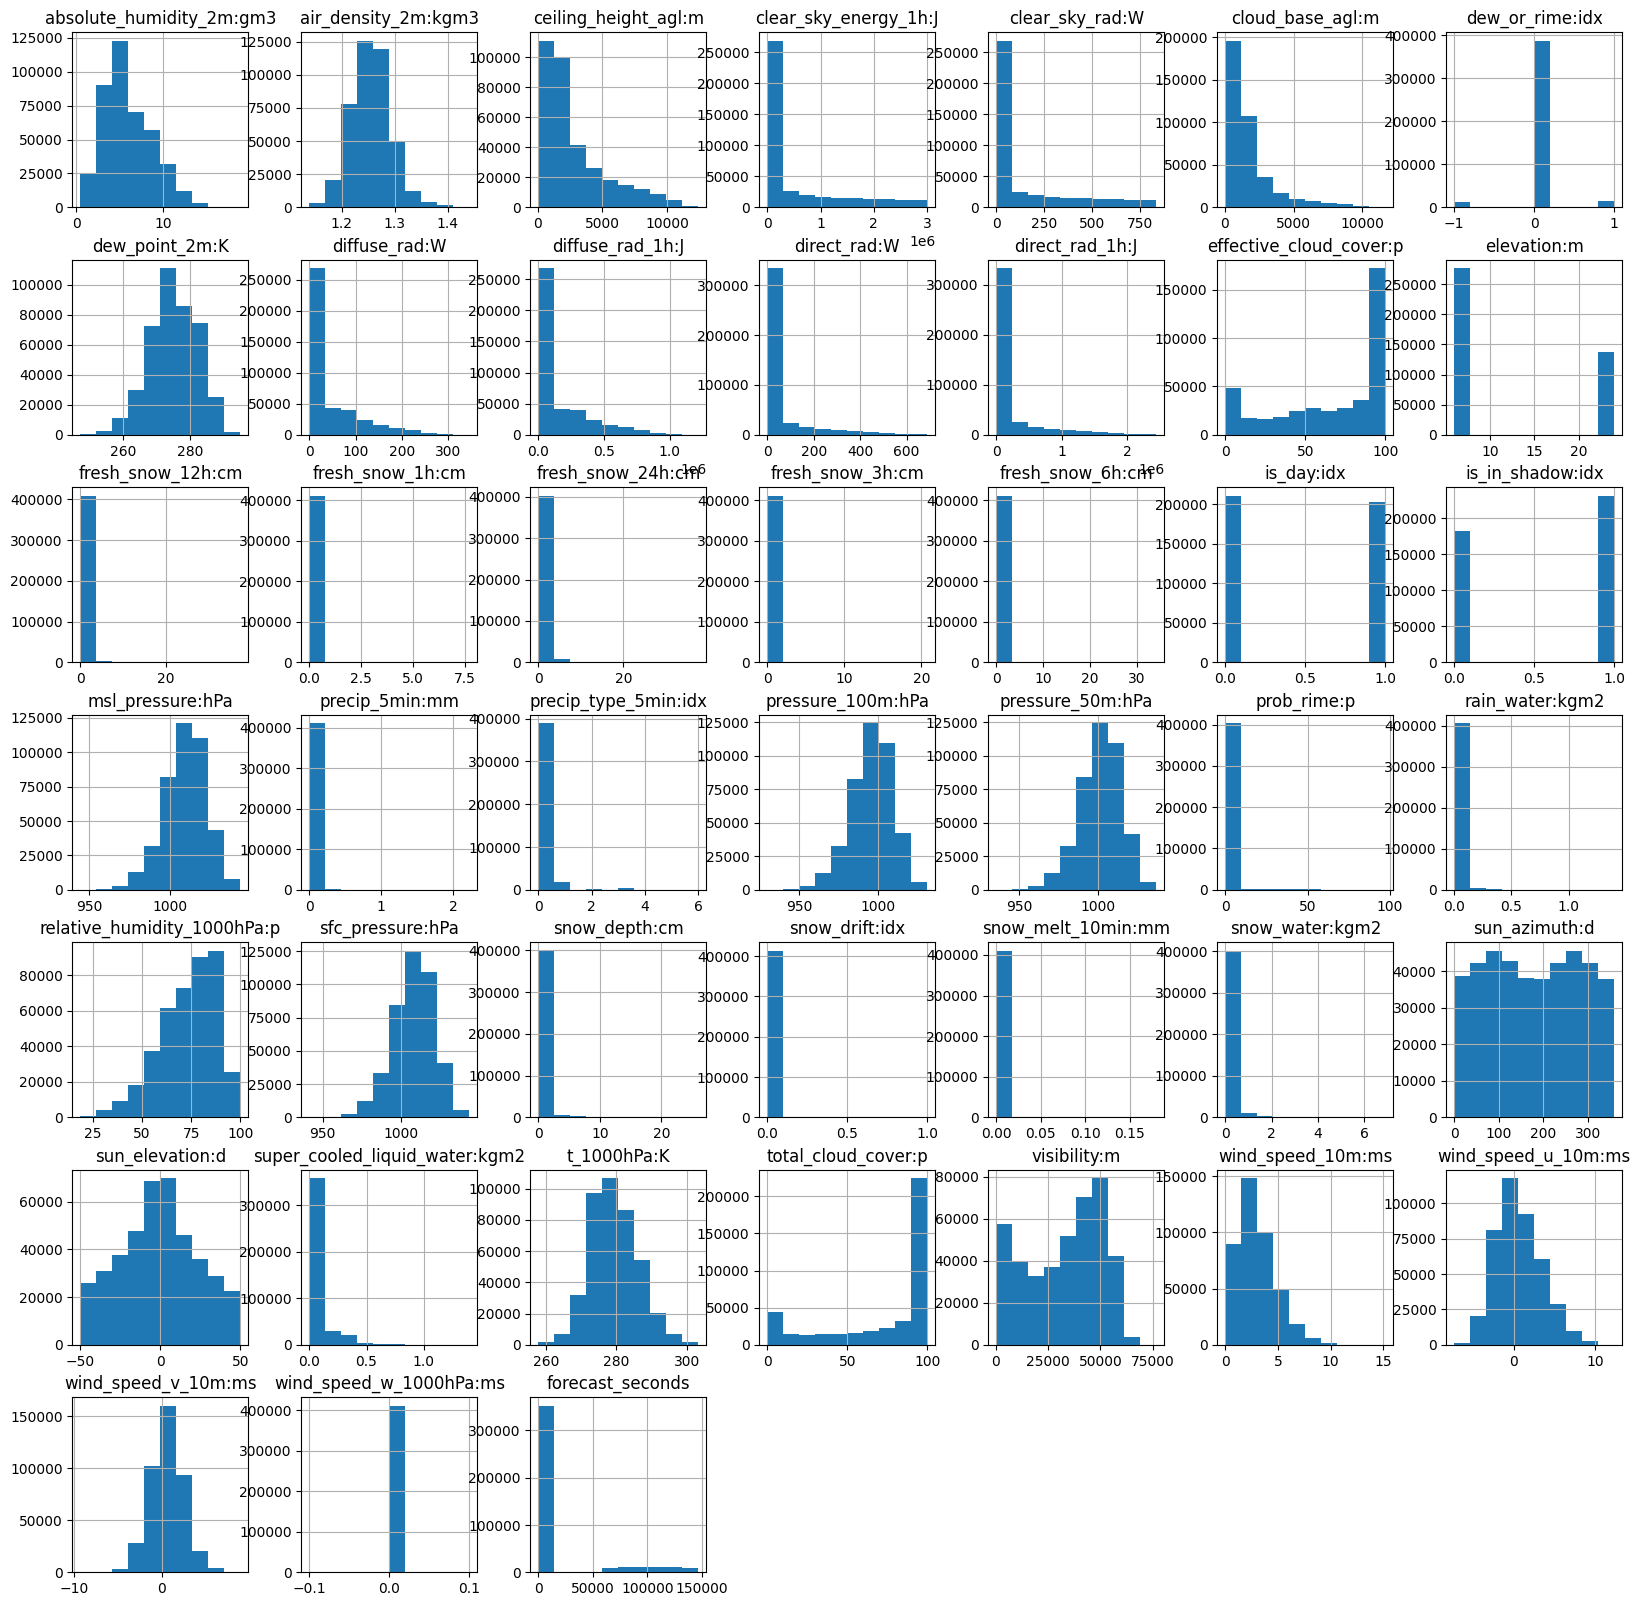

In [12]:
if display_plots:
    pd.concat([Xs["og"][loc][type] for loc in Xs["og"] for type in Xs["og"][loc]]).hist(figsize=(20,20))
    plt.show()

Plot correlation matrix of the data

[(0, 'absolute_humidity_2m:gm3'),
 (1, 'air_density_2m:kgm3'),
 (2, 'ceiling_height_agl:m'),
 (3, 'clear_sky_energy_1h:J'),
 (4, 'clear_sky_rad:W'),
 (5, 'cloud_base_agl:m'),
 (6, 'dew_or_rime:idx'),
 (7, 'dew_point_2m:K'),
 (8, 'diffuse_rad:W'),
 (9, 'diffuse_rad_1h:J'),
 (10, 'direct_rad:W'),
 (11, 'direct_rad_1h:J'),
 (12, 'effective_cloud_cover:p'),
 (13, 'elevation:m'),
 (14, 'fresh_snow_12h:cm'),
 (15, 'fresh_snow_1h:cm'),
 (16, 'fresh_snow_24h:cm'),
 (17, 'fresh_snow_3h:cm'),
 (18, 'fresh_snow_6h:cm'),
 (19, 'is_day:idx'),
 (20, 'is_in_shadow:idx'),
 (21, 'msl_pressure:hPa'),
 (22, 'precip_5min:mm'),
 (23, 'precip_type_5min:idx'),
 (24, 'pressure_100m:hPa'),
 (25, 'pressure_50m:hPa'),
 (26, 'prob_rime:p'),
 (27, 'rain_water:kgm2'),
 (28, 'relative_humidity_1000hPa:p'),
 (29, 'sfc_pressure:hPa'),
 (30, 'snow_depth:cm'),
 (31, 'snow_drift:idx'),
 (32, 'snow_melt_10min:mm'),
 (33, 'snow_water:kgm2'),
 (34, 'sun_azimuth:d'),
 (35, 'sun_elevation:d'),
 (36, 'super_cooled_liquid_water

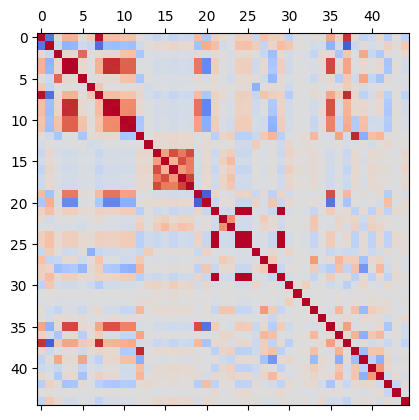

In [13]:
if display_plots:
    display(list(zip(range(len(Xs_cols)), Xs_cols)))
    plt.matshow(pd.concat([Xs["og"][loc][type] for loc in Xs["og"] for type in Xs["og"][loc]]).corr(), cmap="coolwarm", vmin=-1, vmax=1)
    plt.show()

## Gap detection

Plot timeperiod of test dates

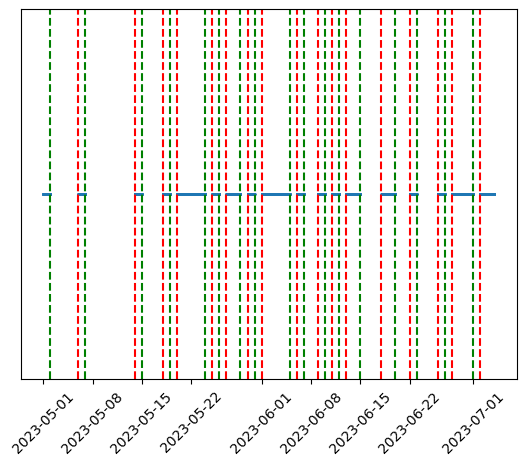

In [14]:
def gap_detection_in_dates(dates, min_gap_time):
    diff = dates.to_series().diff()
    return list(zip(diff[diff.shift(-1) > min_gap_time].index, diff[diff > min_gap_time].index))

def get_non_nan_dates(X):
    return X.index[:1].union(X.dropna(how='all').index.union(X.index[-1:]))

def date_gaps_detection(X, min_gap_time):
    return gap_detection_in_dates(get_non_nan_dates(X), min_gap_time)

min_gap_time = pd.Timedelta(days=1)

if display_plots:
    gaps = gap_detection_in_dates(extract_dates, min_gap_time)
    
    plt.plot(extract_dates, [1] * len(extract_dates), marker='o', markersize=1, linestyle='')

    ax = plt.gca()
    for start_date, end_date in gaps:
        ax.axvline(start_date, linestyle='--', color="green")
        ax.axvline(end_date, linestyle='--', color="red")
    ax.axes.get_yaxis().set_visible(False)
    plt.xticks(rotation=45)
    plt.show()

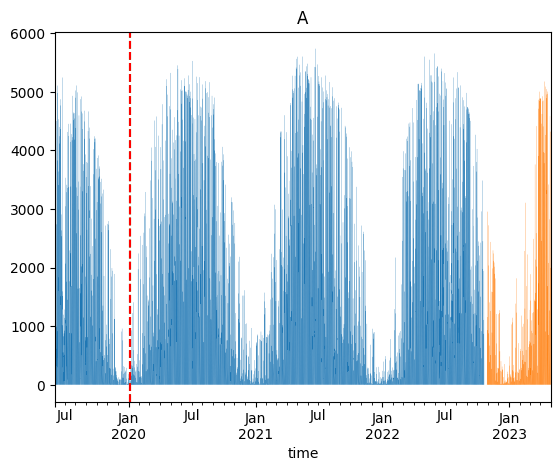

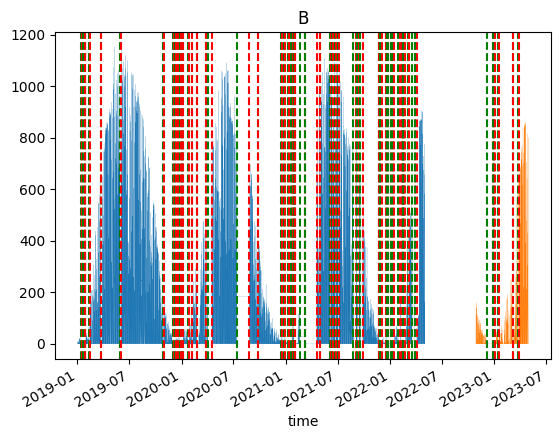

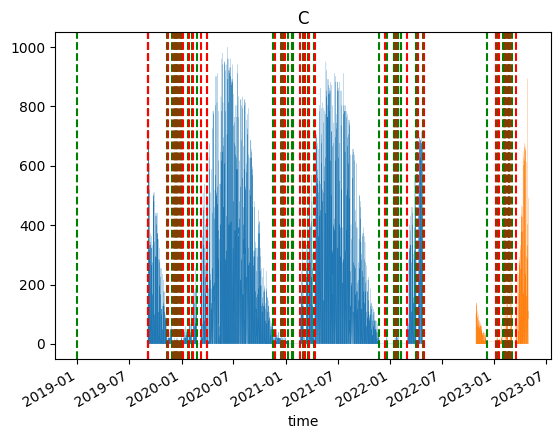

In [15]:
def value_gaps_detection(x, min_gap_time, exclude_vals={}, time_padding=pd.Timedelta(seconds=1)):    
    start_date = x.index[0] - time_padding
    start_val = x.iloc[0]

    gaps_date = []
    index = x.dropna().index
    
    for date in index:
        val = x[date]
        
        if(val != start_val or val in exclude_vals):
            if(date - start_date > min_gap_time):
                gaps_date.append((start_date, date))
    
            start_date = date
            start_val = val

    i = min(x.index.get_loc(index[-1]) + 1, len(x) - 1)
    if(x.index[i] - start_date > min_gap_time):
        gaps_date.append((start_date, x.index[i]))

    if(x.index[-1] - x.index[i-1] > min_gap_time):
        gaps_date.append((x.index[i-1], x.index[-1] + time_padding))

    return gaps_date

if display_plots:
    for loc in ys["og"]:
        for type in ys["og"][loc]:
            ax = ys["og"][loc][type].dropna().plot(lw=0.1)

            gaps = value_gaps_detection(ys["og"][loc][type], min_gap_time)
            for start_date, end_date in gaps:
                ax.axvline(start_date, linestyle='--', color="green")
                ax.axvline(end_date, linestyle='--', color="red")
            ax.set_title(loc)
        plt.show()

## Timeseries data preprocessing

Set constant gaps to NaN

In [16]:
def fill_constant_gaps_with_nan(x, min_gap_time):
    gaps = value_gaps_detection(x, min_gap_time)
    for (start_date, end_date) in gaps:        
        gap_index = x.index[(start_date < x.index) & (x.index < end_date)]
        x[gap_index] = np.nan

min_gap_time = pd.Timedelta(days=1)

for loc in ys["og"]:
    for type in ys["og"][loc]:
        fill_constant_gaps_with_nan(ys["og"][loc][type], min_gap_time)

Reindex to 15 min and 1 hour regular timeseries and combine all the a full timeseries

In [17]:
def regular_index(X, freq, start_padding=pd.Timedelta(0), end_padding=pd.Timedelta(0)):    
    return X.reindex(pd.date_range(start = X.index[0]-start_padding, end = X.index[-1]+end_padding, freq=freq))

gaps = date_gaps_detection(ys["og"]["C"]["obs"], min_gap_time)
Xs["og"]["C"]["obs"] = Xs["og"]["C"]["obs"][Xs["og"]["C"]["obs"].index >= gaps[0][1]]
ys["og"]["C"]["obs"] = ys["og"]["C"]["obs"][ys["og"]["C"]["obs"].index >= gaps[0][1]]

Xs["15min"] = {loc: {} for loc in Xs["og"]}
Xs["1hour"] = {loc: {} for loc in Xs["og"]}

ys["15min"] = {loc: {} for loc in ys["og"]}
ys["1hour"] = {loc: {} for loc in ys["og"]}

end_padding = pd.DateOffset(days=30)

for pre, freq in zip(["15min", "1hour"], ["15T", "H"]):
    for loc in Xs["og"]:
        for type in Xs["og"][loc]:
            Xs[pre][loc][type] = regular_index(Xs["og"][loc][type], freq)
        Xs[pre][loc]["full"] = regular_index(pd.concat(Xs["og"][loc].values()), freq, end_padding=end_padding)

    for loc in ys["og"]:
        for type in ys["og"][loc]:
            ys[pre][loc][type] = regular_index(ys["og"][loc][type], freq)
        ys[pre][loc]["full"] = regular_index(pd.concat(ys["og"][loc].values()), freq)
        
for loc in Xs["og"]:
    Xs["og"][loc]["full"] = pd.concat(Xs["og"][loc].values())
    ys["og"][loc]["full"] = pd.concat(ys["og"][loc].values())

Fill gaps with mean of neighbouring data 

In [18]:
def neighbour_gaps_filling(X, gaps, max_days, intersection_only=True, yearly=False):
    X_copy = X.copy()

    gaps_index = pd.DatetimeIndex([])
    for start_date, end_date in gaps:
        gaps_index = gaps_index.union(X.index[(start_date < X.index) & (X.index < end_date)])
    no_gaps_index = X.index.difference(gaps_index)
    
    for start_date, end_date in gaps:
        if yearly:
            min_days = 1  
        else:
            min_days = (end_date - start_date).days // 2 + 1

        target_index = X.index[(start_date < X.index) & (X.index < end_date)]
        accumelated_index = pd.DatetimeIndex([])

        for days in range(min_days, max_days+1):
            if yearly:
                date_offset = pd.DateOffset(years=days)
            else :
                date_offset = pd.DateOffset(days=days)
            
            past_target_index = no_gaps_index.intersection(target_index - date_offset) + date_offset
            future_target_index = no_gaps_index.intersection(target_index + date_offset) - date_offset
            
            intersection_target_index = past_target_index.intersection(future_target_index).difference(accumelated_index)
            
            if len(intersection_target_index) != 0:
                X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
                    X[X.index.isin(intersection_target_index - date_offset)].values,
                    X[X.index.isin(intersection_target_index + date_offset)].values
                ], axis=0)
                accumelated_index = accumelated_index.union(intersection_target_index)

            if not intersection_only:
                diff_past_target_index = past_target_index.difference(intersection_target_index)
                diff_future_target_index = future_target_index.difference(intersection_target_index)
                
                if len(diff_past_target_index) != 0:
                    X_copy[X.index.isin(diff_past_target_index)] = X[X.index.isin(diff_past_target_index - date_offset)].values
                    accumelated_index = accumelated_index.union(diff_past_target_index)
                    
                if len(diff_future_target_index) != 0:
                    X_copy[X.index.isin(diff_future_target_index)] = X[X.index.isin(diff_future_target_index + date_offset)].values
                    accumelated_index = accumelated_index.union(diff_future_target_index)

            if len(target_index.difference(accumelated_index)) == 0:
                break
    
    return X_copy

def while_fill_gaps(min_gap_time, max_days, X1, X2=None, intersection_only=True, yearly=False):
    last_gaps = []
    while True:
        gaps = date_gaps_detection(X1, min_gap_time)
        
        if gaps == last_gaps:
            break
        last_gaps = gaps
        
        if X2 is not None:
            X2 = neighbour_gaps_filling(X2, gaps, max_days, intersection_only, yearly)

        X1 = neighbour_gaps_filling(X1, gaps, max_days, intersection_only, yearly)

    if X2 is None:
        return X1
    else:
        return X1, X2

/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:3

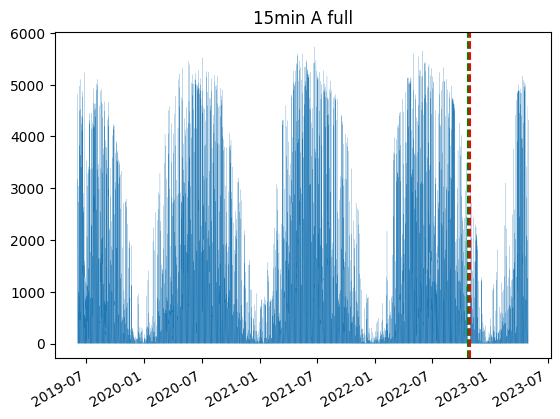

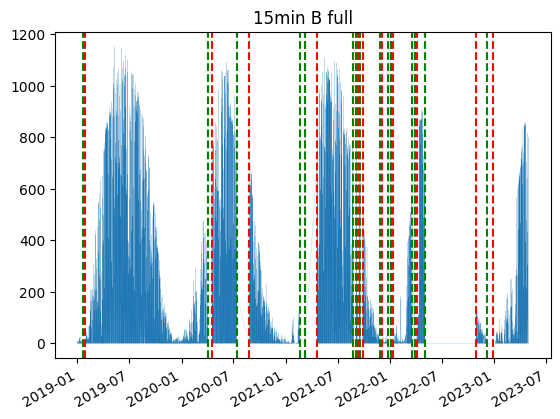

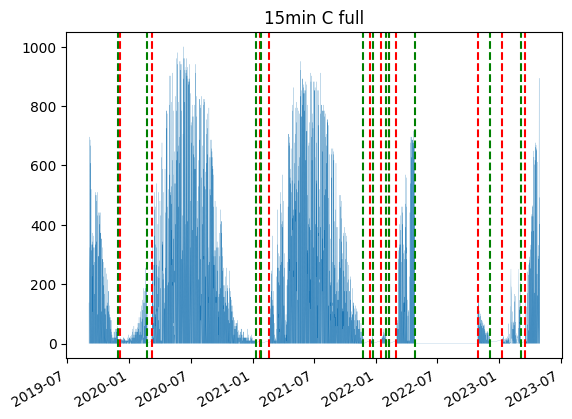

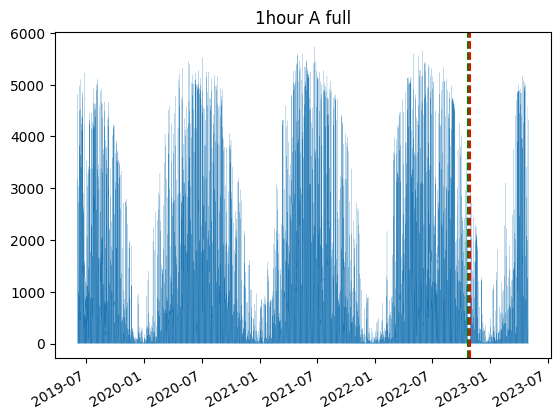

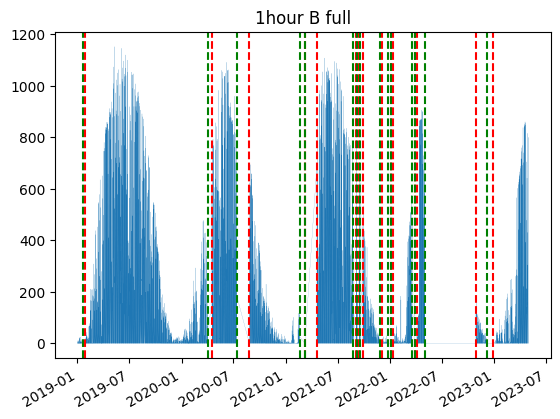

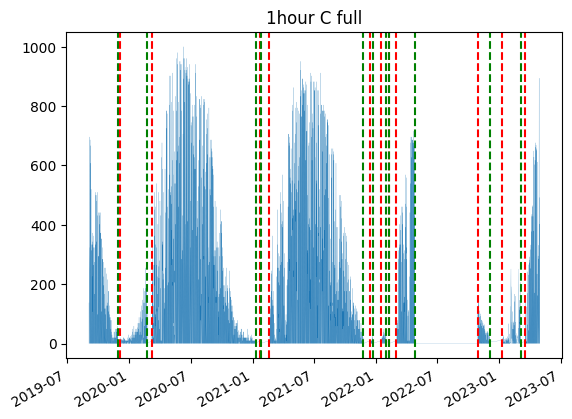

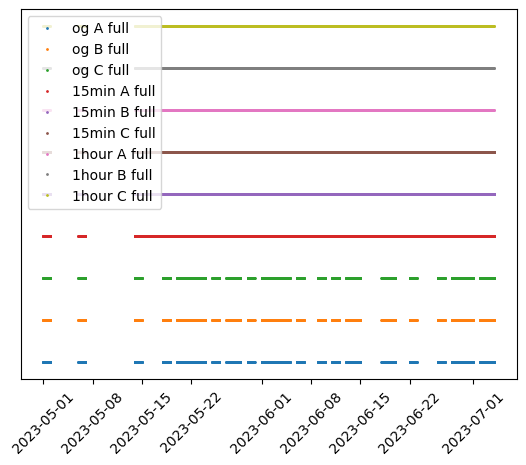

In [19]:
max_days = 3

for pre in ["15min", "1hour"]:
    for loc in Xs[pre]:
        for type in ys[pre][loc]:
            ys[pre][loc][type], Xs[pre][loc][type] = while_fill_gaps(min_gap_time, max_days, ys[pre][loc][type], Xs[pre][loc][type])
        
        for type in Xs[pre][loc]:
            Xs[pre][loc][type] = while_fill_gaps(min_gap_time, max_days, Xs[pre][loc][type])

if display_plots:
    for pre in ["15min", "1hour"]:
        for loc in ys[pre]:
            ax = ys[pre][loc]["full"].dropna().plot(lw=0.1)
            
            gaps = date_gaps_detection(ys[pre][loc]["full"], min_gap_time)
            for start_date, end_date in gaps:
                ax.axvline(start_date, linestyle='--', color="green")
                ax.axvline(end_date, linestyle='--', color="red")
            
            plt.title(pre + " " + loc + " full")
            plt.show()

    legends = []
    y = 0
    for pre in Xs:
        for loc in Xs[pre]:
            y = y + 1
            legends.append(pre + " " + loc + " " + type)
            dates = Xs[pre][loc]["test"].dropna(how='all').index
            plt.plot(dates, [y] * len(dates), marker='o', markersize=1, linestyle='')

    plt.gca().axes.get_yaxis().set_visible(False)
    plt.legend(legends)
    plt.xticks(rotation=45)
    plt.show()

/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_4726/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([


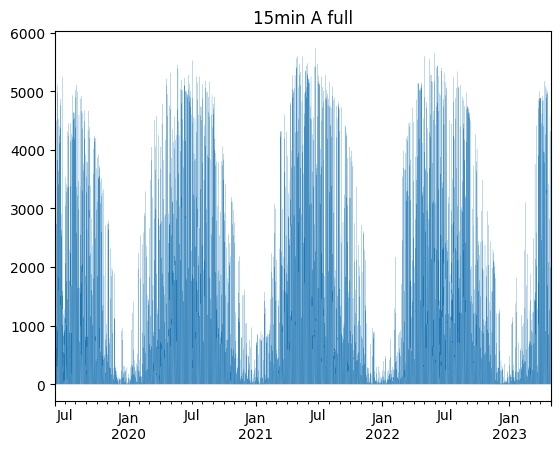

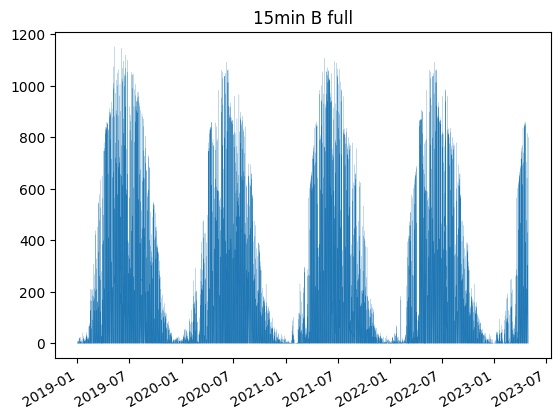

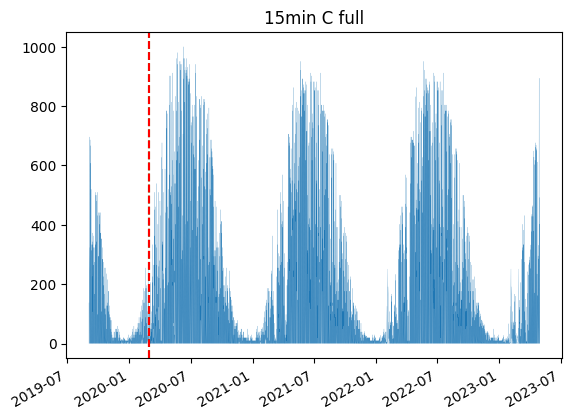

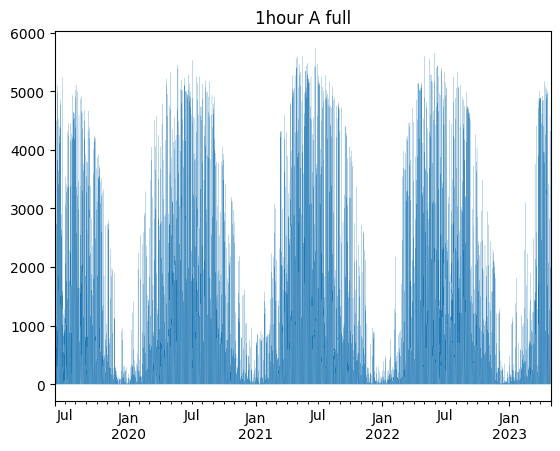

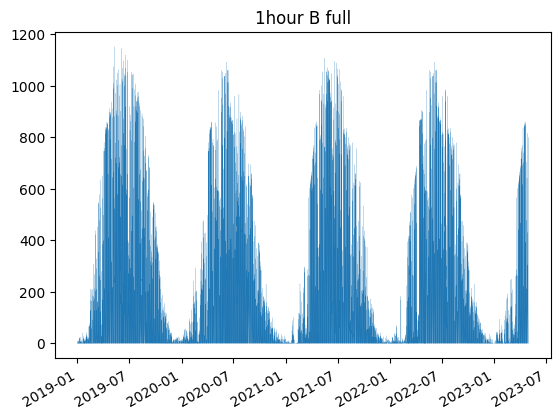

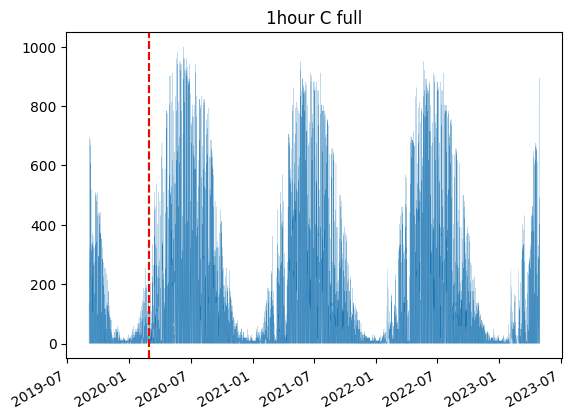

In [20]:
max_years = 3

for pre in ["15min", "1hour"]:
    for loc in Xs[pre]:
        for type in ys[pre][loc]:
            fill_constant_gaps_with_nan(ys[pre][loc][type], min_gap_time)
            ys[pre][loc][type], Xs[pre][loc][type] = while_fill_gaps(
                min_gap_time, 
                max_years,
                ys[pre][loc][type], 
                Xs[pre][loc][type],
                intersection_only = False,
                yearly = True,
            )

        for type in Xs[pre][loc]:
            Xs[pre][loc][type] = while_fill_gaps(
                min_gap_time, 
                max_years,
                Xs[pre][loc][type], 
                intersection_only = False,
                yearly = True,
            )

if display_plots:
    for pre in ["15min", "1hour"]:
        for loc in ys[pre]:
            ax = ys[pre][loc]["full"].dropna().plot(lw=0.1)

            gaps = date_gaps_detection(ys[pre][loc]["full"], min_gap_time)
            for start_date, end_date in gaps:
                ax.axvline(start_date, linestyle='--', color="green")
                ax.axvline(end_date, linestyle='--', color="red")
            
            plt.title(pre + " " + loc + " full")
            plt.show()

Time interpolate missing values

In [21]:
def time_interpolate(X):
    return X.interpolate(method='time', limit_direction="both")

for pre in ["15min", "1hour"]:
    for loc in Xs[pre]:
        for type in Xs[pre][loc]:
            Xs[pre][loc][type] = time_interpolate(Xs[pre][loc][type])

for pre in ["15min", "1hour"]:
    for loc in ys[pre]:
        for type in ys[pre][loc]:
            ys[pre][loc][type] = time_interpolate(ys[pre][loc][type])

Check for nan values

In [22]:
def nested_values(d, exclude_keys={}):
    values = []
    for key, value in d.items():
        if key not in exclude_keys:
            if isinstance(value, dict):
                values.extend(nested_values(value, exclude_keys))
            else:
                values.append(value)
    return values

display(pd.concat(nested_values(Xs, exclude_keys={"og"})).isna().sum())
display(pd.concat(nested_values(ys, exclude_keys={"og"})).isna().sum())

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
elevation:m                       0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2             

0

Check that the period is correct

In [23]:
for pre in ["15min", "1hour"]:
    for loc in Xs[pre]:
        for type in Xs[pre][loc]:
            display(
                "",
                "Xs " + pre + " " + loc + " " + type, 
                Xs[pre][loc][type].index[0], 
                Xs[pre][loc][type].index[-1], 
                Xs[pre][loc][type].index.to_series().diff().value_counts()
            )

    for loc in ys[pre]:
        for type in ys[pre][loc]:
            display(
                "",
                "ys " + pre + " " + loc + " " + type, 
                ys[pre][loc][type].index[0], 
                ys[pre][loc][type].index[-1], 
                ys[pre][loc][type].index.to_series().diff().value_counts()
            )

''

'Xs 15min A obs'

Timestamp('2019-06-02 22:00:00')

Timestamp('2022-10-21 01:00:00')

0 days 00:15:00    118668
Name: count, dtype: int64

''

'Xs 15min A est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    17671
Name: count, dtype: int64

''

'Xs 15min A test'

Timestamp('2023-05-01 00:00:00')

Timestamp('2023-07-03 23:45:00')

0 days 00:15:00    6143
Name: count, dtype: int64

''

'Xs 15min A full'

Timestamp('2019-06-02 22:00:00')

Timestamp('2023-08-02 23:45:00')

0 days 00:15:00    146119
Name: count, dtype: int64

''

'Xs 15min B obs'

Timestamp('2018-12-31 23:00:00')

Timestamp('2022-05-03 00:00:00')

0 days 00:15:00    116932
Name: count, dtype: int64

''

'Xs 15min B est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    17671
Name: count, dtype: int64

''

'Xs 15min B test'

Timestamp('2023-05-01 00:00:00')

Timestamp('2023-07-03 23:45:00')

0 days 00:15:00    6143
Name: count, dtype: int64

''

'Xs 15min B full'

Timestamp('2018-12-31 23:00:00')

Timestamp('2023-08-02 23:45:00')

0 days 00:15:00    160803
Name: count, dtype: int64

''

'Xs 15min C obs'

Timestamp('2019-09-04 08:00:00')

Timestamp('2022-05-01 22:00:00')

0 days 00:15:00    93176
Name: count, dtype: int64

''

'Xs 15min C est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    17671
Name: count, dtype: int64

''

'Xs 15min C test'

Timestamp('2023-05-01 00:00:00')

Timestamp('2023-07-03 23:45:00')

0 days 00:15:00    6143
Name: count, dtype: int64

''

'Xs 15min C full'

Timestamp('2019-09-04 08:00:00')

Timestamp('2023-08-02 23:45:00')

0 days 00:15:00    137151
Name: count, dtype: int64

''

'ys 15min A obs'

Timestamp('2019-06-02 22:00:00')

Timestamp('2022-10-21 01:00:00')

0 days 00:15:00    118668
Name: count, dtype: int64

''

'ys 15min A est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    17671
Name: count, dtype: int64

''

'ys 15min A full'

Timestamp('2019-06-02 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    137095
Name: count, dtype: int64

''

'ys 15min B obs'

Timestamp('2018-12-31 23:00:00')

Timestamp('2022-05-03 00:00:00')

0 days 00:15:00    116932
Name: count, dtype: int64

''

'ys 15min B est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    17671
Name: count, dtype: int64

''

'ys 15min B full'

Timestamp('2018-12-31 23:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    151779
Name: count, dtype: int64

''

'ys 15min C obs'

Timestamp('2019-09-04 08:00:00')

Timestamp('2022-05-01 22:00:00')

0 days 00:15:00    93176
Name: count, dtype: int64

''

'ys 15min C est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    17671
Name: count, dtype: int64

''

'ys 15min C full'

Timestamp('2019-09-04 08:00:00')

Timestamp('2023-04-30 23:45:00')

0 days 00:15:00    128127
Name: count, dtype: int64

''

'Xs 1hour A obs'

Timestamp('2019-06-02 22:00:00')

Timestamp('2022-10-21 01:00:00')

0 days 01:00:00    29667
Name: count, dtype: int64

''

'Xs 1hour A est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    4417
Name: count, dtype: int64

''

'Xs 1hour A test'

Timestamp('2023-05-01 00:00:00')

Timestamp('2023-07-03 23:00:00')

0 days 01:00:00    1535
Name: count, dtype: int64

''

'Xs 1hour A full'

Timestamp('2019-06-02 22:00:00')

Timestamp('2023-08-02 23:00:00')

0 days 01:00:00    36529
Name: count, dtype: int64

''

'Xs 1hour B obs'

Timestamp('2018-12-31 23:00:00')

Timestamp('2022-05-03 00:00:00')

0 days 01:00:00    29233
Name: count, dtype: int64

''

'Xs 1hour B est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    4417
Name: count, dtype: int64

''

'Xs 1hour B test'

Timestamp('2023-05-01 00:00:00')

Timestamp('2023-07-03 23:00:00')

0 days 01:00:00    1535
Name: count, dtype: int64

''

'Xs 1hour B full'

Timestamp('2018-12-31 23:00:00')

Timestamp('2023-08-02 23:00:00')

0 days 01:00:00    40200
Name: count, dtype: int64

''

'Xs 1hour C obs'

Timestamp('2019-09-04 08:00:00')

Timestamp('2022-05-01 22:00:00')

0 days 01:00:00    23294
Name: count, dtype: int64

''

'Xs 1hour C est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    4417
Name: count, dtype: int64

''

'Xs 1hour C test'

Timestamp('2023-05-01 00:00:00')

Timestamp('2023-07-03 23:00:00')

0 days 01:00:00    1535
Name: count, dtype: int64

''

'Xs 1hour C full'

Timestamp('2019-09-04 08:00:00')

Timestamp('2023-08-02 23:00:00')

0 days 01:00:00    34287
Name: count, dtype: int64

''

'ys 1hour A obs'

Timestamp('2019-06-02 22:00:00')

Timestamp('2022-10-21 01:00:00')

0 days 01:00:00    29667
Name: count, dtype: int64

''

'ys 1hour A est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    4417
Name: count, dtype: int64

''

'ys 1hour A full'

Timestamp('2019-06-02 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    34273
Name: count, dtype: int64

''

'ys 1hour B obs'

Timestamp('2018-12-31 23:00:00')

Timestamp('2022-05-03 00:00:00')

0 days 01:00:00    29233
Name: count, dtype: int64

''

'ys 1hour B est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    4417
Name: count, dtype: int64

''

'ys 1hour B full'

Timestamp('2018-12-31 23:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    37944
Name: count, dtype: int64

''

'ys 1hour C obs'

Timestamp('2019-09-04 08:00:00')

Timestamp('2022-05-01 22:00:00')

0 days 01:00:00    23294
Name: count, dtype: int64

''

'ys 1hour C est'

Timestamp('2022-10-28 22:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    4417
Name: count, dtype: int64

''

'ys 1hour C full'

Timestamp('2019-09-04 08:00:00')

Timestamp('2023-04-30 23:00:00')

0 days 01:00:00    32031
Name: count, dtype: int64

## More data preprocessing

One hot encoding of categorial values in X

In [24]:
def one_hot_encoding(X):
    return pd.get_dummies(X)

Z-score normalizing of numeric values in X

In [25]:
class StandardScaler:
    def __init__(self, X):
        self.means = X.mean(numeric_only=True)
        self.stds = X.std(numeric_only=True)

    def normalize(self, X):
        indices = self.indices(X)
        X_copy = X.copy()
        X_copy[indices] = (X[indices] - self.means[indices]) / self.stds[indices]
        return X_copy

    def denormalize(self, X):
        indices = self.indices(X)
        X_copy = X.copy()
        X_copy[indices] = X[indices] * self.stds[indices] + self.means[indices]
        return X_copy

    def indices(self, X):
        return self.means.index.intersection(X.columns)

Polynomial expansion of numeric values in X to degree n
    
Example:
If [x y] = X then
- degree 1: [1 x y]
- degree 2: [1 x y xx xy yy]
- degree 3: [1 x y xx xy yy xxx xxy xyy yyy]
- ...

Note: Since multiplication is commutitative then 
    xy = yx, xxy = xyx = yxx, xyy = yxy = yyx
so we skip non-lexicographically sorted multiplications.

In [26]:
def is_sorted(lst):
    return all(lst[i] <= lst[i+1] for i in range(len(lst) - 1))

def polynomial_expansion(X, degree=2, with_constant_term=False):
    cols = X.select_dtypes(include=["number"]).columns
    X_num = X.select_dtypes(include=["number"]).to_numpy()
    (m,n) = X_num.shape

    xs = [X]
    if(with_constant_term):
        xs.append(pd.Series(np.ones(m), name='1'))

    for d in range(2, degree+1):
        for indices in filter(is_sorted, itertools.product(range(n), repeat=d)):
            x = np.ones(m)
            for j in indices:
                x *= X_num[:,j]
            xs.append(pd.Series(x, name="_x_".join([cols[i] for i in indices])))

    return pd.concat(xs, axis=1)

Test functions

In [27]:
X = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9],
    'D': ['a', 'b', 'c'],
})

scaler = StandardScaler(X)
X_norm = scaler.normalize(X)

print(scaler.denormalize(X_norm))
print(X_norm)
print(one_hot_encoding(X))
print(polynomial_expansion(X))

     A    B    C  D
0  1.0  4.0  7.0  a
1  2.0  5.0  8.0  b
2  3.0  6.0  9.0  c
     A    B    C  D
0 -1.0 -1.0 -1.0  a
1  0.0  0.0  0.0  b
2  1.0  1.0  1.0  c
   A  B  C    D_a    D_b    D_c
0  1  4  7   True  False  False
1  2  5  8  False   True  False
2  3  6  9  False  False   True
   A  B  C  D  A_x_A  A_x_B  A_x_C  B_x_B  B_x_C  C_x_C
0  1  4  7  a    1.0    4.0    7.0   16.0   28.0   49.0
1  2  5  8  b    4.0   10.0   16.0   25.0   40.0   64.0
2  3  6  9  c    9.0   18.0   27.0   36.0   54.0   81.0


Normalize Xs and ys to standard scalar with sklearn

In [28]:
from sklearn.preprocessing import StandardScaler

pers = ["og", "15min", "1hour"]

scaler_Xs = {}
scaler_ys = {}

for per in pers:
    per_norm = per + " norm"
    
    Xs[per_norm] = {}
    scaler_Xs[per_norm] = StandardScaler().fit(pd.concat(nested_values(Xs[per], exclude_keys={"full", "BC"})).to_numpy())
    for loc in Xs[per]:
        Xs[per_norm][loc] = {}
        for type in Xs[per][loc]:
            Xs[per_norm][loc][type] = pd.DataFrame(
                scaler_Xs[per_norm].transform(Xs[per][loc][type].to_numpy()), 
                columns = Xs[per][loc][type].columns, 
                index = Xs[per][loc][type].index,
            )
            display("Xs " + per + " " + loc + " " + type, Xs[per_norm][loc][type].mean().mean(), Xs[per_norm][loc][type].std().mean())

    ys[per_norm] = {}
    scaler_ys[per_norm] = StandardScaler().fit(pd.concat(nested_values(ys[per], exclude_keys={"full", "BC"})).to_numpy().reshape(-1, 1))
    for loc in ys[per]:
        ys[per_norm][loc] = {}
        for type in ys[per][loc]:
            ys[per_norm][loc][type] = pd.Series(
                scaler_ys[per_norm].transform(ys[per][loc][type].to_numpy().reshape(-1, 1)).flatten(), 
                name = ys[per][loc][type].name, 
                index = ys[per][loc][type].index,
            )
            display("ys " + per + " " + loc + " " + type, ys[per_norm][loc][type].mean().mean(), ys[per_norm][loc][type].std().mean())

'Xs og A obs'

-0.008288124

0.83411705

'Xs og A est'

-0.028572252

0.8524391

'Xs og A test'

0.21519922

0.7450849

'Xs og A full'

-0.0062301755

0.87306595

'Xs og B obs'

-0.023923755

0.89870673

'Xs og B est'

-0.032447986

0.8235769

'Xs og B test'

0.2168467

0.7377114

'Xs og B full'

-0.019998977

0.922741

'Xs og C obs'

0.020069884

1.0144265

'Xs og C est'

0.058882184

1.0521233

'Xs og C test'

0.25088984

0.7858603

'Xs og C full'

0.031876385

1.0538588

'ys og A obs'

0.4315303247508085

1.4703201066221252

'ys og A est'

0.017331815777186167

1.0935706671388288

'ys og A full'

0.3777768655185005

1.4338133518259328

'ys og B obs'

-0.2557283493874295

0.2711471003910041

'ys og B est'

-0.33542088494999744

0.17154564716690635

'ys og B full'

-0.2666974383673065

0.26115932016770815

'ys og C obs'

-0.27044218440987694

0.22951312501399632

'ys og C est'

-0.3461873063788279

0.13286982770909597

'ys og C full'

-0.2806944532453777

0.22046861368787787

'Xs 15min A obs'

-0.009039283

0.85198087

'Xs 15min A est'

-0.028948965

0.87768257

'Xs 15min A test'

0.1761858

0.7152862

'Xs 15min A full'

0.00042915784

0.8901977

'Xs 15min B obs'

-0.03347733

0.8891248

'Xs 15min B est'

-0.02958888

0.8447472

'Xs 15min B test'

0.1775547

0.7092423

'Xs 15min B full'

-0.010973231

0.9097995

'Xs 15min C obs'

0.015041741

0.9882246

'Xs 15min C est'

0.061920807

1.0767468

'Xs 15min C test'

0.22014576

0.782179

'Xs 15min C full'

0.05113249

0.9916011

'ys 15min A obs'

0.5208422298676814

1.5735980069135351

'ys 15min A est'

0.07294256514616816

1.17291992308684

'ys 15min A full'

0.4595207024074875

1.5318507415134577

'ys 15min B obs'

-0.23027729350356083

0.2826040634880328

'ys 15min B est'

-0.320228422458125

0.16999974086222544

'ys 15min B full'

-0.2312012066857395

0.2803591102092069

'ys 15min C obs'

-0.26409109801349323

0.2261892045520974

'ys 15min C est'

-0.3340629190185563

0.119197744999724

'ys 15min C full'

-0.2603793005263443

0.22912635045943655

'Xs 1hour A obs'

-0.009032092

0.8534427

'Xs 1hour A est'

-0.029295985

0.87656903

'Xs 1hour A test'

0.18366908

0.7123817

'Xs 1hour A full'

0.00047464916

0.89097214

'Xs 1hour B obs'

-0.03365225

0.8914899

'Xs 1hour B est'

-0.030085325

0.8438984

'Xs 1hour B test'

0.18497612

0.7092652

'Xs 1hour B full'

-0.011056645

0.91161186

'Xs 1hour C obs'

0.0140522905

0.9866449

'Xs 1hour C est'

0.062221117

1.0795586

'Xs 1hour C test'

0.22501369

0.7716052

'Xs 1hour C full'

0.05052713

0.9912007

'ys 1hour A obs'

0.5152136925558286

1.5764917400968237

'ys 1hour A est'

0.07216441593958321

1.173121405968174

'ys 1hour A full'

0.45457562366330495

1.5343067036193938

'ys 1hour B obs'

-0.22779077742445727

0.2822966091900894

'ys 1hour B est'

-0.31676857772852596

0.16980794947812436

'ys 1hour B full'

-0.2287009871891661

0.2800468615060174

'ys 1hour C obs'

-0.2612370678812417

0.2260222361463965

'ys 1hour C est'

-0.33045395211468254

0.11890062254689324

'ys 1hour C full'

-0.25756245200862443

0.22893375158877705

Do PCA of Xs with sklearn

'15min: 32'

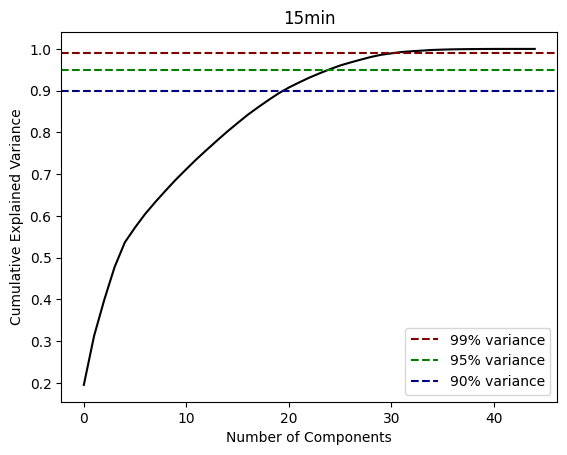

'1hour: 32'

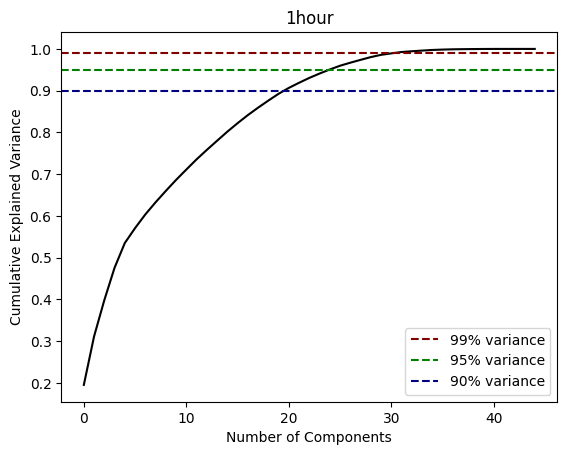

In [29]:
from sklearn.decomposition import PCA

variance_threshold = 0.99
pca_Xs = {}

for per in ["15min", "1hour"]:
    per_pca = per + " pca"
    per_norm = per + " norm"
    
    Xs[per_pca] = {}
    pca_Xs[per_pca] = PCA().fit(pd.concat(nested_values(Xs[per_norm], exclude_keys={"full", "BC"})).to_numpy())

    explained_variance = pca_Xs[per_pca].explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    n_components = (cumulative_variance < variance_threshold).sum() + 1
    display(per + ": " + str(n_components))
    
    if display_plots:
        plt.plot(cumulative_variance, color="black")
        plt.title(per)
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.axhline(0.99, linestyle='--', label='99% variance', color=(0.5, 0.0, 0.0))
        plt.axhline(0.95, linestyle='--', label='95% variance', color=(0.0, 0.5, 0.0))
        plt.axhline(0.90, linestyle='--', label='90% variance', color=(0.0, 0.0, 0.5))
        plt.legend()
        plt.show()
    
    for loc in Xs[per]:
        Xs[per_pca][loc] = {}
        for type in Xs[per][loc]:
            Xs[per_pca][loc][type] = pd.DataFrame(
                pca_Xs[per_pca].transform(Xs[per_norm][loc][type].to_numpy())[:,:n_components], 
                columns = [f'PC{i}' for i in range(n_components)], 
                index = Xs[per][loc][type].index,
            )

Plot histogram of the data

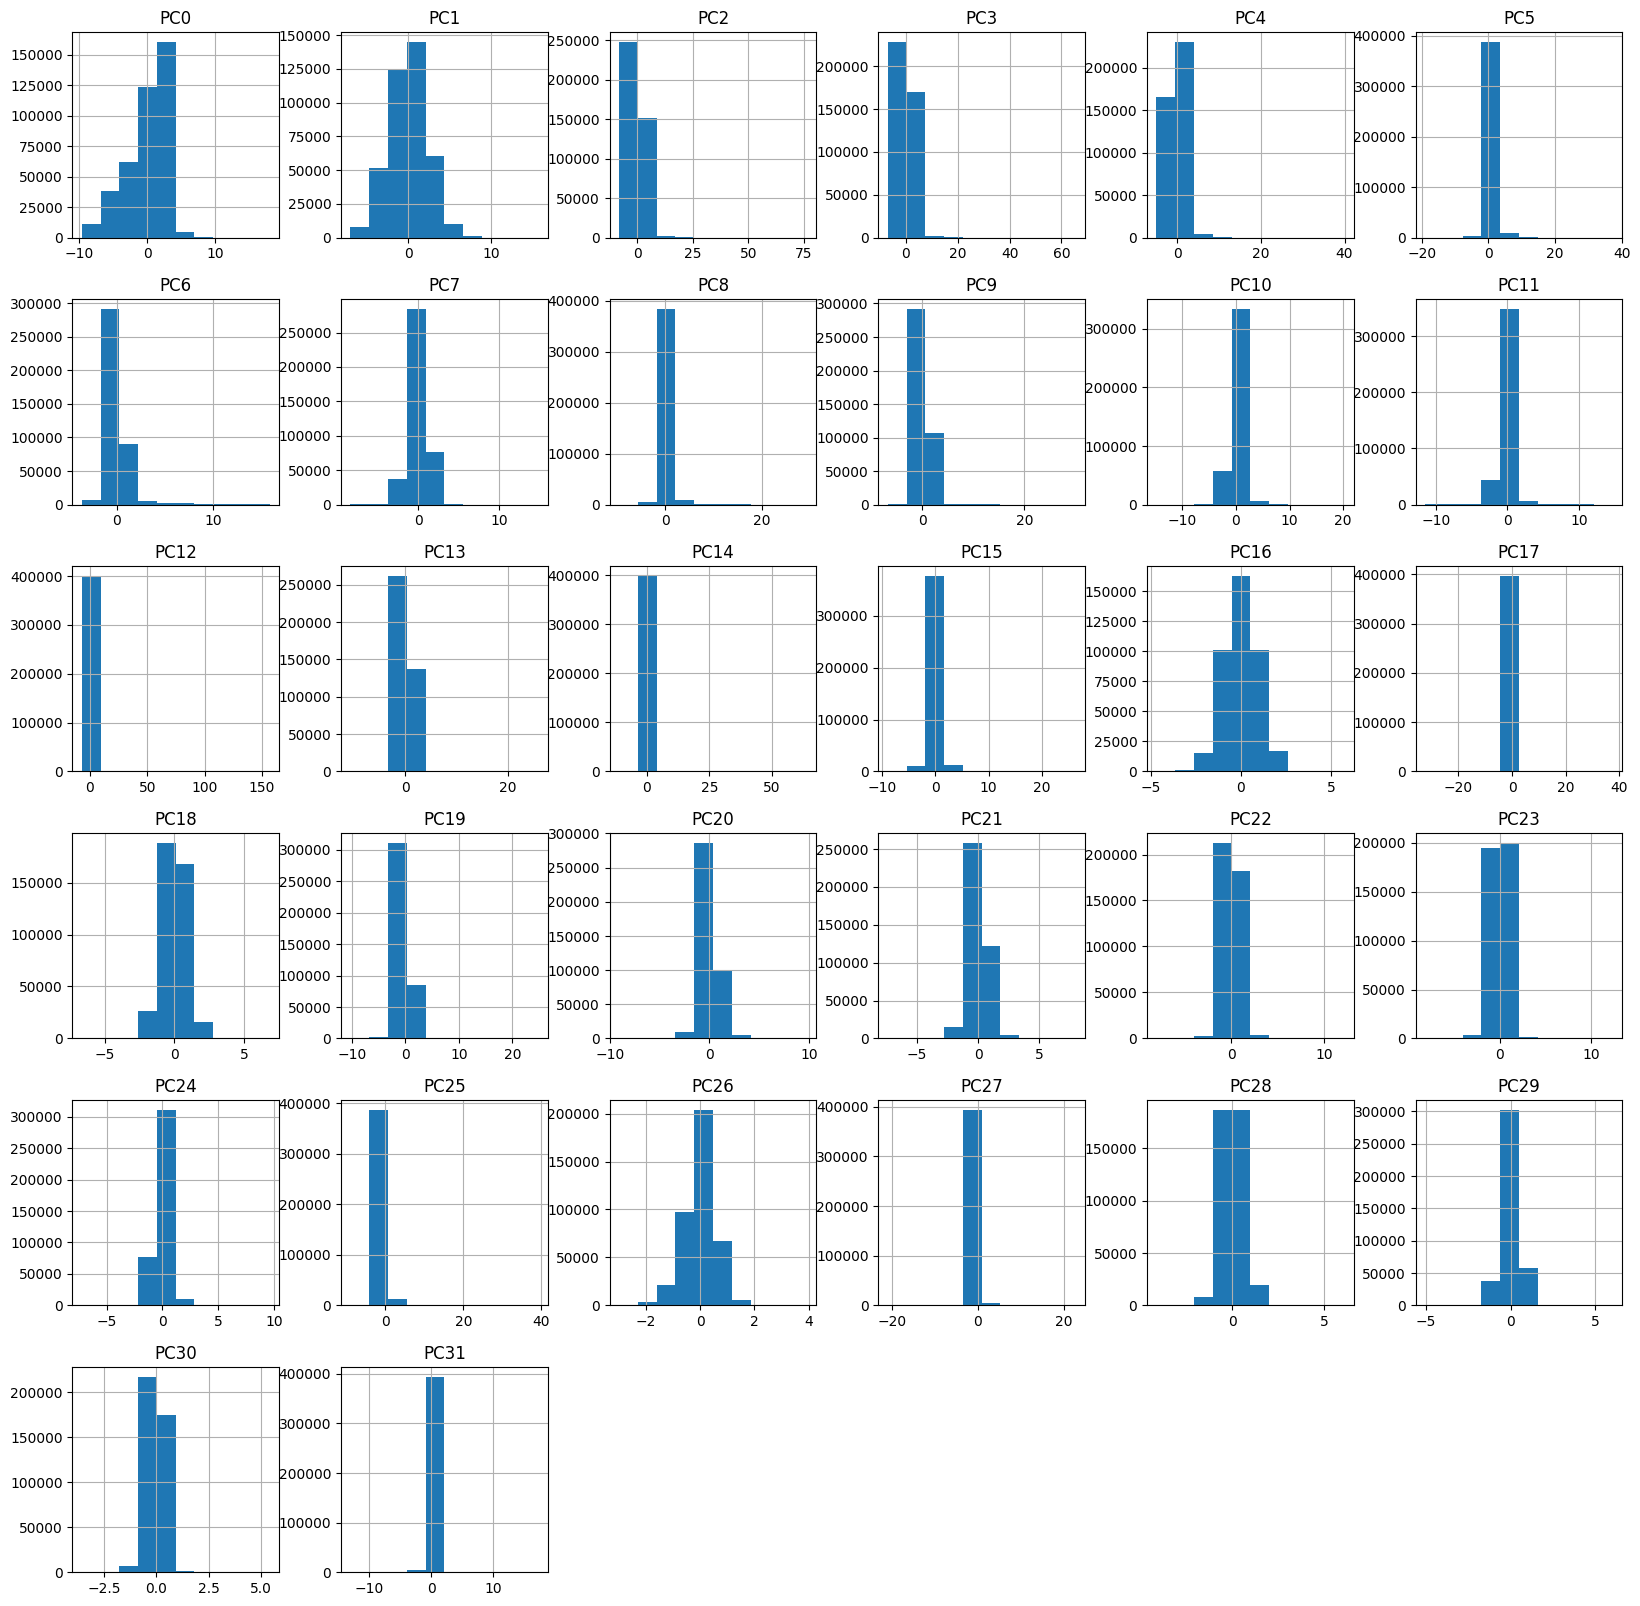

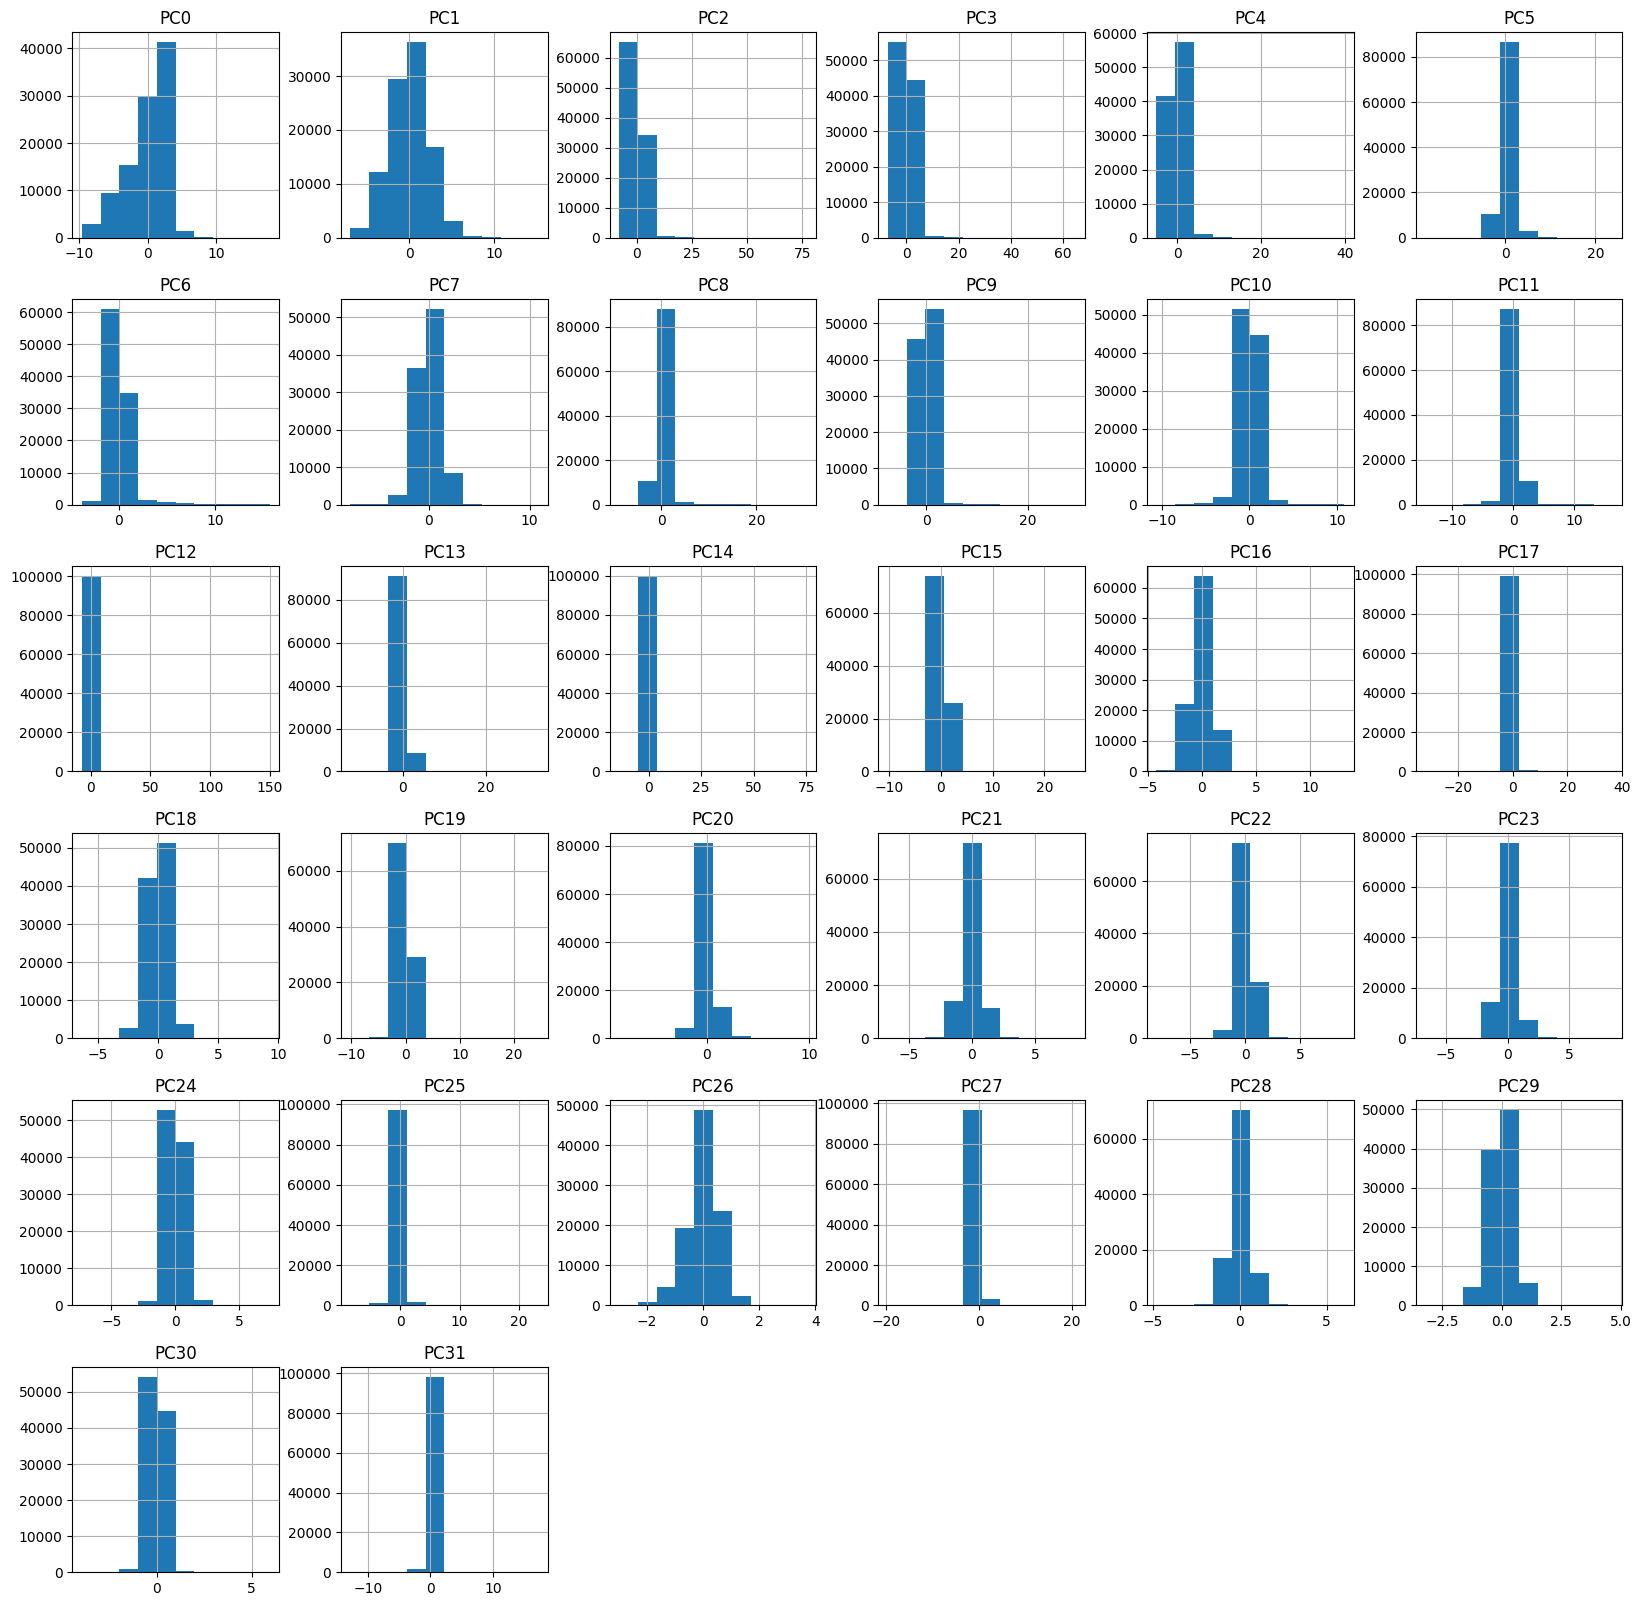

In [30]:
if display_plots:
    for per in ["15min pca", "1hour pca"]:
        pd.concat(nested_values(Xs[per], exclude_keys={"full", "BC"})).hist(figsize=(20,20))
        plt.show()

Plot correlation matrix of the data

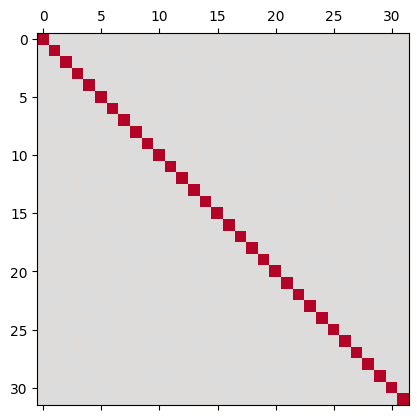

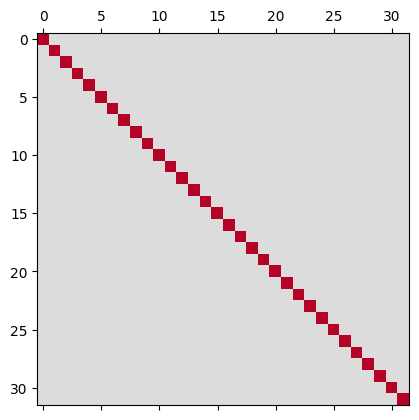

In [31]:
if display_plots:
    for per in ["15min pca", "1hour pca"]:
        plt.matshow(pd.concat(nested_values(Xs[per], exclude_keys={"full", "BC"})).corr(), cmap="coolwarm", vmin=-1, vmax=1)
        plt.show()

## TSfresh timeseries feature extraction

In [32]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

def tsfresh_format_og(Xs, pre, full):
    Xys_loc_train = []
    Xs_loc_test = []

    y_name = "pv_measurement"
    loc_name = "location"
    time_name = "time"
    
    for loc in ["A", "B", "C"]:
        if full:
            X_loc_full = time_interpolate(Xs[pre][loc]["full"])
            y_loc_train = ys[pre][loc]["full"].copy()
            X_loc_train = X_loc_full[X_loc_full.index <= y_loc_train.index[-1]].copy()
            X_loc_test = X_loc_full[X_loc_full.index > y_loc_train.index[-1]].copy()
        else:
            X_loc_train = time_interpolate(pd.concat([Xs[pre][loc]["obs"], Xs[pre][loc]["est"]]))
            y_loc_train = pd.concat([ys[pre][loc]["obs"], ys[pre][loc]["est"]])
            X_loc_test = time_interpolate(Xs[pre][loc]["test"].copy())
        
        Xy_loc_train = X_loc_train.join(y_loc_train, how='outer')
        Xy_loc_train = Xy_loc_train.reset_index().rename(columns={'index': time_name})
        Xy_loc_train[loc_name] = loc
        
        X_loc_test = X_loc_test.reset_index().rename(columns={'index': time_name})
        X_loc_test[loc_name] = loc

        Xys_loc_train.append(Xy_loc_train)
        Xs_loc_test.append(X_loc_test)

    Xy_train = pd.concat(Xys_loc_train).dropna(subset=[y_name])
    X_test = pd.concat(Xs_loc_test)

    X = pd.concat([Xy_train.drop(columns=[y_name]), X_test]).reset_index(drop=True).reset_index().rename(columns={'index': "id"})
    y = Xy_train[y_name].reset_index(drop=True)
    l = X[loc_name]
        
    return X.drop(columns=[loc_name]), y, l

do_tsfresh = False
if do_tsfresh:
    X, y, l = tsfresh_format_og(Xs, "og", full=False)
    
    display(X)
    display(y)
    display(l)
    
    extracted_features = extract_features(X, column_id="id", column_sort="time")
    
    impute(extracted_features)
    features_filtered = select_features(extracted_features.head(len(y)), y)
    
    X_tsfresh = extracted_features[features_filtered.columns]
    X_tsfresh["location"] = l
    
    Xs["og tsfresh"] = X_tsfresh
    ys["og tsfresh"] = y

## Darts setup

Convert to darts timeseries

In [33]:
from darts import TimeSeries

display_plots = True

loc_dummies = {
    "A": pd.DataFrame({'location_A': [1], 'location_B': [0], 'location_C': [0]}),
    "B": pd.DataFrame({'location_A': [0], 'location_B': [1], 'location_C': [0]}),
    "C": pd.DataFrame({'location_A': [0], 'location_B': [0], 'location_C': [1]}),
}

covs = {}
for pre in ["15min", "1hour", "15min norm", "1hour norm", "15min pca", "1hour pca"]:
    covs[pre] = {loc: {type: TimeSeries.from_dataframe(Xs[pre][loc][type], static_covariates=loc_dummies[loc]) for type in Xs[pre][loc] } for loc in Xs[pre]}

tars = {}
for pre in ["15min", "1hour", "15min norm", "1hour norm"]:
    tars[pre] = {loc: {type: TimeSeries.from_series(ys[pre][loc][type], static_covariates=loc_dummies[loc]) for type in ys[pre][loc] } for loc in ys[pre]}

locs = ["A", "B", "C"]

assert are_all_equal([ys["15min"][loc][type].index[-1] for loc in locs for type in ["est", "full"]])
assert are_all_equal([ys["1hour"][loc][type].index[-1] for loc in locs for type in ["est", "full"]])

n_15min = len(pd.date_range(start=ys["15min"]["A"]["est"].index[-1], end=extract_dates[-1], freq='15T'))
n_1hour = len(pd.date_range(start=ys["1hour"]["A"]["est"].index[-1], end=extract_dates[-1], freq='H'))

Darts filter

In [34]:
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import ExpSineSquared

do_gaussian_filter = False
if do_gaussian_filter:
    gaussian_filter = GaussianProcessFilter(kernel=ExpSineSquared())
    
    tars["1hour gaussian"] = {loc: gaussian_filter.filter(TimeSeries.from_series(regular_index(ys["og"][loc]["full"], "H"))) for loc in ys["og"]}
    
    if display_plots:
        for loc in tars["1hour gaussian"]:
            tars["1hour gaussian"][loc]["full"].plot()
            plt.show()

Save predictions to csv file

In [35]:
def extract_and_save(ys, file_name, tars_per, path="predictions", extract_dates=extract_dates, scaler_ys=scaler_ys):
    y = pd.concat([ys[loc].pd_series()[extract_dates[extract_dates.minute == 0]] for loc in ys])

    if tars_per in scaler_ys:
        y = pd.Series(
            scaler_ys[tars_per].inverse_transform(y.to_numpy().reshape(-1, 1)).flatten(),
            name = y.name, 
            index = y.index,
        )
    
    y[y < 0] = 0
    y.name = "prediction"
    y = y.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    y.to_csv(os.path.join(path, file_name), index=False)
    
    return y

## CatBoost

Train and make predicitons

In [37]:
from darts.models import CatBoostModel

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_cat = {}

do_cat = True
if do_cat:
    for loc in locs:
        cat = CatBoostModel(lags=5*24, lags_future_covariates=(24,24))
        cat.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_cat[loc] = cat.predict(n_1hour, tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])

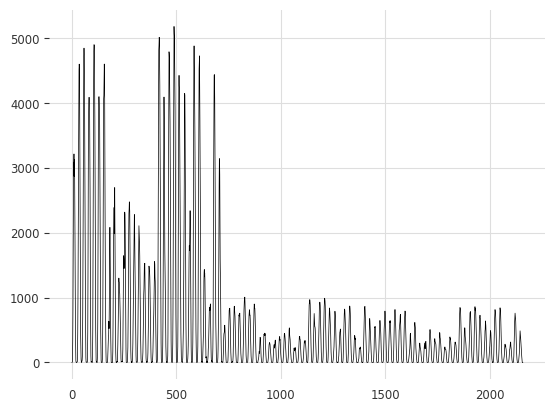

In [38]:
if do_cat:
    y = extract_and_save(ys_cat, "cat_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

## XGBoost

Train and make predicitons

In [39]:
from darts.models import XGBModel

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_xgboost = {}

do_xgboost = True
if do_xgboost:
    for loc in locs:
        xgb = XGBModel(lags=5*24, lags_future_covariates=(24,24))
        xgb.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_xgboost[loc] = xgb.predict(n_1hour, tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])

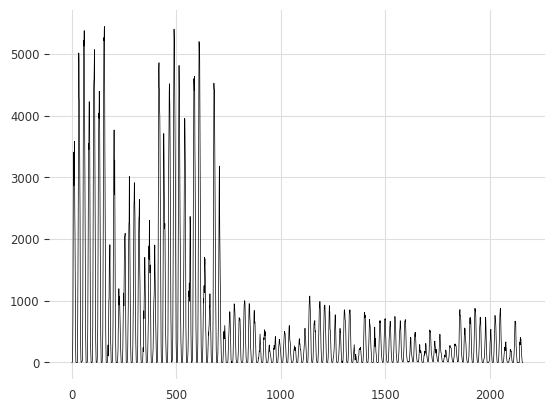

In [40]:
if do_xgboost:
    y = extract_and_save(ys_xgboost, "xbg_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

## LightGBM

Train and make predicitons

In [41]:
from darts.models import LightGBMModel

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_light = {}

do_light = True
if do_light:
    for loc in locs:
        light = LightGBMModel(lags=5*24, lags_future_covariates=(24,24))
        light.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_light[loc] = light.predict(n_1hour, tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.727240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 358008
[LightGBM] [Info] Number of data points in the train set: 34154, number of used features: 2136
[LightGBM] [Info] Start training from score 627.562496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.767448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377064
[LightGBM] [Info] Number of data points in the train set: 37825, number of used features: 2136
[LightGBM] [Info] Start training from score 110.338613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.694250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382555
[LightGBM] [Info] Number of data points in the train set: 31912, number of used features: 2184
[LightGBM] 

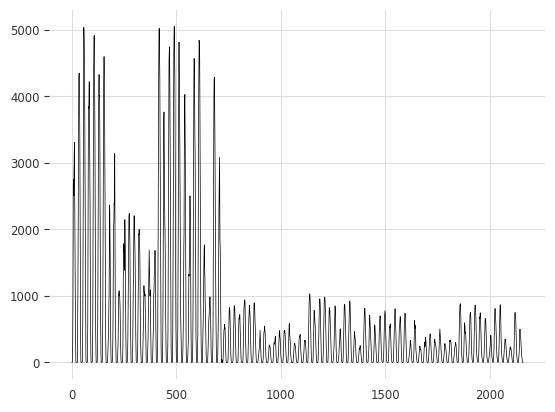

In [42]:
if do_light:
    y = extract_and_save(ys_light, "light_gbm_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

## RandomForest

Train and make predicitons

In [43]:
from darts.models import RandomForest

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_forest = {}

do_forest = False
if do_forest:
    for loc in tars[tars_per]:
        forest_model = RandomForest(lags=5*24, lags_future_covariates=(24,24))
        forest_model.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_forest[loc] = forest_model.predict(n_1hour, future_covariates=covs[covs_per][loc][type])

In [44]:
if do_forest:
    y = extract_and_save(ys_forest, "random_forest_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

## Prophet

Train and make predicitons

In [45]:
from darts.models import Prophet

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_prophet = {}

do_prophet = True
if do_prophet:
    for loc in tars[tars_per]:
        prophet = Prophet()
        prophet.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_prophet[loc] = prophet.predict(n_1hour, future_covariates=covs[covs_per][loc][type])

18:32:17 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:15 - cmdstanpy - INFO - Chain [1] start processing
18:33:57 - cmdstanpy - INFO - Chain [1] done processing
18:34:02 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing


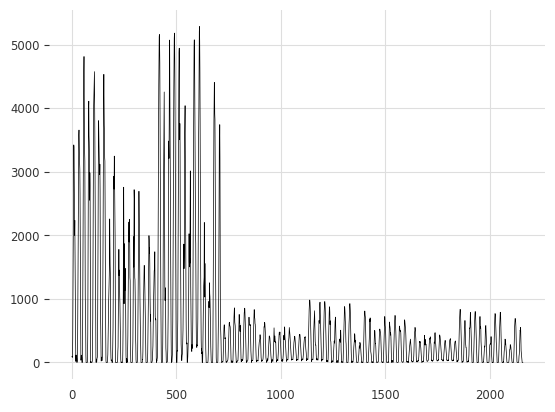

In [46]:
if do_prophet:
    y = extract_and_save(ys_prophet, "prophet_1hour.csv", tars_per)
    if True:
        y["prediction"].plot(lw=0.5)
        plt.show()

## AutoARIMA

Train and make predicitons

In [47]:
from darts.models import AutoARIMA

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_autoarima = {}

do_autoarima = False
if do_autoarima:
    for loc in tars[tars_per]:
        ari = AutoARIMA()
        ari.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_autoarima[loc] = ari.predict(n_1hour, future_covariates=covs[covs_per][loc][type])

In [48]:
if do_autoarima:
    y = extract_and_save(ys_autoarima, "ari_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

## RNN model

Train and make predicitons

In [49]:
from darts.models import RNNModel

tars_per = "1hour norm"
covs_per = "1hour pca"
type = "full"

ys_rnn = {}

do_rnn = False
if do_rnn:    
    rnn_model = RNNModel(
        model = 'LSTM',
        input_chunk_length = 3 * 24,
        training_length = 5 * 24,
        n_rnn_layers = 3,
        hidden_dim = 50,
        n_epochs = 100,
        dropout = 0.1,
    )
    
    rnn_model.fit([tars[tars_per][loc][type] for loc in locs], future_covariates=[covs[covs_per][loc][type] for loc in locs], verbose=True)
    for loc in locs:
        ys_rnn[loc] = rnn_model.predict(n_1hour, tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])

In [50]:
if do_rnn:
    y = extract_and_save(ys_rnn, "rnn_pca_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

## CatBoost with optuna for hyperparamater optimization

Train and make predicitons

In [51]:
import optuna
from darts.models import CatBoostModel
from darts.metrics import mae

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_cat_optuna = {}

# Create a TimeSeries object
train_series, val_series = tars[tars_per]["A"][type].split_after(7*24)
future_covariates = covs[covs_per]["A"][type]

def objective(trial):
    trial_number = trial.number
    print(f"\nStarting Trial #{trial_number + 1}")
    
    # Define the search space for common CatBoost hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        # Add other hyperparameters as needed
    }

    # Create a CatBoost model with the suggested hyperparameters
    model = CatBoostModel(lags=5*24, lags_future_covariates=(24, 24), **params)

    # Train the model
    model.fit(train_series, future_covariates=future_covariates)

    # Make predictions on the validation set
    val_predictions = model.predict(len(val_series), future_covariates=future_covariates)

    # Evaluate the model using Mean Absolute Error (MAE)
    val_mae = mae(val_series, val_predictions)

    return val_mae

do_cat_optuna = False
if do_cat_optuna:

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    # Get the best parameters and their corresponding mean absolute error (MAE)
    best_params = study.best_params
    best_mae = study.best_value
    
    print("Best Parameters:", best_params)
    print("Best Validation MAE:", best_mae)

    for loc in locs:
        cat = CatBoostModel(lags=5*24, lags_future_covariates=(24, 24), **best_params)
        cat.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_cat_optuna[loc] = cat.predict(n_1hour, future_covariates=covs[covs_per][loc][type])

In [52]:
if do_cat_optuna:
    y = extract_and_save(ys_cat_optuna, "cat_optuna_1hour.csv", tars_per)
    if display_plots:
        y["prediction"].plot(lw=0.5)
        plt.show()

# Old notebook

## Setup

Requires Python 3.10 and Poetry 1.6. Run setup commands to begin:
```
!poetry install
!poetry run jupyter lab
```

Dependencies from pyproject.toml
```
python = "3.10.x"
torch = "^2.1.0"
torchvision = "^0.16.0"
torchaudio = "^2.1.0"
kaleido = "0.2.1"
pycaret = {extras = ["full"], version = "^3.1.0"}
pandas = {version = "^1.3.0", extras = ["parquet"]}
```

In [2]:
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = None

## Load data

In [3]:
raw_data = {
    "A": {
        "test_est": pd.read_parquet(os.path.join("data", "A", "X_test_estimated.parquet")),
        "train_est": pd.read_parquet(os.path.join("data", "A", "X_train_estimated.parquet")),
        "train_obs": pd.read_parquet(os.path.join("data", "A", "X_train_observed.parquet")),
        "train_tar": pd.read_parquet(os.path.join("data", "A", "train_targets.parquet")),
    },
    "B": {
        "test_est": pd.read_parquet(os.path.join("data", "B", "X_test_estimated.parquet")),
        "train_est": pd.read_parquet(os.path.join("data", "B", "X_train_estimated.parquet")),
        "train_obs": pd.read_parquet(os.path.join("data", "B", "X_train_observed.parquet")),
        "train_tar": pd.read_parquet(os.path.join("data", "B", "train_targets.parquet")),
    },
    "C": {
        "test_est": pd.read_parquet(os.path.join("data", "C", "X_test_estimated.parquet")),
        "train_est": pd.read_parquet(os.path.join("data", "C", "X_train_estimated.parquet")),
        "train_obs": pd.read_parquet(os.path.join("data", "C", "X_train_observed.parquet")),
        "train_tar": pd.read_parquet(os.path.join("data", "C", "train_targets.parquet")),
    },
}

In [4]:
raw_data["C"]["test_est"]

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0    2023-04-30 07:00:04 2023-05-01 00:00:00                       4.2   
1    2023-04-30 07:00:04 2023-05-01 00:15:00                       4.2   
2    2023-04-30 07:00:04 2023-05-01 00:30:00                       4.1   
3    2023-04-30 07:00:04 2023-05-01 00:45:00                       4.1   
4    2023-04-30 07:00:04 2023-05-01 01:00:00                       4.1   
...                  ...                 ...                       ...   
2875 2023-07-02 07:00:31 2023-07-03 22:45:00                       9.0   
2876 2023-07-02 07:00:31 2023-07-03 23:00:00                       9.0   
2877 2023-07-02 07:00:31 2023-07-03 23:15:00                       9.0   
2878 2023-07-02 07:00:31 2023-07-03 23:30:00                       8.9   
2879 2023-07-02 07:00:31 2023-07-03 23:45:00                       8.9   

      air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                   1.286                   NaN                    0.0   
1                   1.286                   NaN                    0.0   
2                   1.286                   NaN                    0.0   
3                   1.286                   NaN                    0.0   
4                   1.286                   NaN                    0.0   
...                   ...                   ...                    ...   
2875                1.207           2003.500000                    0.0   
2876                1.207           2005.599976                    0.0   
2877                1.207           2005.500000                    0.0   
2878                1.207           2005.500000                    0.0   
2879                1.207           2005.500000                    0.0   

      clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                 0.0       1178.000000              0.0      271.100006   
1                 0.0       1217.000000              0.0      271.100006   
2                 0.0       1256.000000              0.0      271.000000   
3                 0.0       1295.000000              0.0      270.899994   
4                 0.0       1334.099976              0.0      270.899994   
...               ...               ...              ...             ...   
2875              0.0       1573.000000              0.0      282.600006   
2876              0.0       1471.000000              0.0      282.500000   
2877              0.0       1346.900024              0.0      282.500000   
2878              0.0       1222.800049              0.0      282.500000   
2879              0.0       1098.699951              0.0      282.399994   

      diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0               0.0               0.0           0.0              0.0   
1               0.0               0.0           0.0              0.0   
2               0.0               0.0           0.0              0.0   
3               0.0               0.0           0.0              0.0   
4               0.0               0.0           0.0              0.0   
...             ...               ...           ...              ...   
2875            0.0               0.0           0.0              0.0   
2876            0.0               0.0           0.0              0.0   
2877            0.0               0.0           0.0              0.0   
2878            0.0               0.0           0.0              0.0   
2879            0.0               0.0           0.0              0.0   

      effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   73.699997         24.0                0.0   
1                   70.800003         24.0                0.0   
2                   67.900002         24.0                0.0   
3                   64.800003         24.0                0.0   
4                   61.599998         24.0                0.0   
...                       ...          ...                ...   
2875

In [5]:
raw_data["C"]["train_est"]

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0     2022-10-27 07:00:18 2022-10-28 22:00:00                       8.3   
1     2022-10-27 07:00:18 2022-10-28 22:15:00                       8.3   
2     2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3     2022-10-27 07:00:18 2022-10-28 22:45:00                       8.2   
4     2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   
...                   ...                 ...                       ...   
17571 2023-04-29 07:00:05 2023-04-30 22:45:00                       4.4   
17572 2023-04-29 07:00:05 2023-04-30 23:00:00                       4.4   
17573 2023-04-29 07:00:05 2023-04-30 23:15:00                       4.4   
17574 2023-04-29 07:00:05 2023-04-30 23:30:00                       4.4   
17575 2023-04-29 07:00:05 2023-04-30 23:45:00                       4.4   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                    1.231           1427.400024                    0.0   
1                    1.231           2089.000000                    0.0   
2                    1.231           2750.500000                    0.0   
3                    1.230           3412.100098                    0.0   
4                    1.230           4073.699951                    0.0   
...                    ...                   ...                    ...   
17571                1.280           1034.599976                    0.0   
17572                1.280            897.200012                    0.0   
17573                1.280           1288.699951                    0.0   
17574                1.280           1680.300049                    0.0   
17575                1.279           2071.800049                    0.0   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0                  0.0       1215.800049              1.0      281.200012   
1                  0.0       1425.900024              1.0      281.200012   
2                  0.0       1636.099976              1.0      281.100006   
3                  0.0       1846.199951              1.0      281.100006   
4                  0.0       2056.399902              1.0      281.100006   
...                ...               ...              ...             ...   
17571              0.0        562.299988              0.0      272.000000   
17572              0.0        569.500000              0.0      272.000000   
17573              0.0        562.299988              0.0      272.000000   
17574              0.0        555.099976              0.0      271.899994   
17575              0.0        547.799988              0.0      271.899994   

       diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                0.0               0.0           0.0              0.0   
1                0.0               0.0           0.0              0.0   
2                0.0               0.0           0.0              0.0   
3                0.0               0.0           0.0              0.0   
4                0.0               0.0           0.0              0.0   
...              ...               ...           ...              ...   
17571            0.0               0.0           0.0              0.0   
17572            0.0               0.0           0.0              0.0   
17573            0.0               0.0           0.0              0.0   
17574            0.0               0.0           0.0              0.0   
17575            0.0               0.0           0.0              0.0   

       effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                   100.000000         24.0                0.0   
1                   100.000000         24.0                0.0   
2                   100.000000         24.0                0.0   
3                   100.000000         24.0                0.0   
4                   100.000000         24.0                0.0   
...             

In [6]:
raw_data["C"]["train_obs"]

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0      2019-01-01 00:00:00                       5.6                1.240   
1      2019-01-01 00:15:00                       5.5                1.241   
2      2019-01-01 00:30:00                       5.4                1.241   
3      2019-01-01 00:45:00                       5.4                1.241   
4      2019-01-01 01:00:00                       5.3                1.241   
...                    ...                       ...                  ...   
116820 2022-05-01 21:00:00                       4.9                1.257   
116821 2022-05-01 21:15:00                       4.9                1.256   
116822 2022-05-01 21:30:00                       4.9                1.256   
116823 2022-05-01 21:45:00                       4.8                1.255   
116824 2022-05-01 22:00:00                       4.8                1.255   

        ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0                1153.599976                    0.0              0.0   
1                1137.900024                    0.0              0.0   
2                1122.199951                    0.0              0.0   
3                1106.400024                    0.0              0.0   
4                1090.599976                    0.0              0.0   
...                      ...                    ...              ...   
116820           2652.000000                    0.0              0.0   
116821           2375.300049                    0.0              0.0   
116822           2098.699951                    0.0              0.0   
116823           1822.000000                    0.0              0.0   
116824           1545.300049                    0.0              0.0   

        cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0            1153.599976              1.0      275.200012            0.0   
1            1137.900024              1.0      275.100006            0.0   
2            1122.199951              1.0      274.899994            0.0   
3            1106.400024              1.0      274.700012            0.0   
4            1090.599976              1.0      274.500000            0.0   
...                  ...              ...             ...            ...   
116820       1536.500000              0.0      273.600006            0.0   
116821       1484.500000              0.0      273.600006            0.0   
116822       1432.500000              0.0      273.500000            0.0   
116823       1380.400024              0.0      273.399994            0.0   
116824       1328.400024              0.0      273.399994            0.0   

        diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  \
0                    0.0           0.0              0.0   
1                    0.0           0.0              0.0   
2                    0.0           0.0              0.0   
3                    0.0           0.0              0.0   
4                    0.0           0.0              0.0   
...                  ...           ...              ...   
116820               0.0           0.0              0.0   
116821               0.0           0.0              0.0   
116822               0.0           0.0              0.0   
116823               0.0           0.0              0.0   
116824               0.0           0.0              0.0   

        effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0                     63.599998         24.0                0.0   
1                     74.900002         24.0                0.0   
2                     84.300003         24.0                0.0   
3                     92.000000         24.0                0.0   
4                     98.000000         24.0                0.0   
...                         ...          ...                ...   
116820                95.000000         24.0                0.0   
116821                97.000000         24.0                0.0  

In [7]:
raw_data["C"]["train_tar"]

time  pv_measurement
0     2018-12-31 23:00:00             NaN
1     2019-01-01 00:00:00             NaN
2     2019-01-01 01:00:00             NaN
3     2019-01-01 02:00:00             NaN
4     2019-01-01 03:00:00             NaN
...                   ...             ...
32150 2023-04-30 19:00:00           50.96
32151 2023-04-30 20:00:00            2.94
32152 2023-04-30 21:00:00            0.00
32153 2023-04-30 22:00:00           -0.00
32154 2023-04-30 23:00:00           -0.00

[32155 rows x 2 columns]

## Preproccess data

In [8]:
# Create empty list of location train data and location test data
location_train_data = []
location_test_data = []

# Copy raw data dictonary and loop through it
raw_data_copy = copy.deepcopy(raw_data)
for k in raw_data_copy:

    # Add a column with the difference between date_forecast and date_calc in seconds and remove date_calc
    raw_data_copy[k]["train_obs"]["forecast_seconds"] = 0
    raw_data_copy[k]["train_est"]["forecast_seconds"] = (raw_data_copy[k]["train_est"]["date_forecast"] - raw_data_copy[k]["train_est"]["date_calc"]).apply(lambda x: x.total_seconds())
    del raw_data_copy[k]["train_est"]["date_calc"]
    raw_data_copy[k]["test_est"]["forecast_seconds"] = (raw_data_copy[k]["test_est"]["date_forecast"] - raw_data_copy[k]["test_est"]["date_calc"]).apply(lambda x: x.total_seconds())
    del raw_data_copy[k]["test_est"]["date_calc"]

    # Add a column with location
    raw_data_copy[k]["train_obs"]["location"] = k
    raw_data_copy[k]["train_est"]["location"] = k
    raw_data_copy[k]["test_est"]["location"] = k

    # Concat and merge train observed, train estimated and train target to one dataframe and push to location_train_data list
    location_train_data.append(pd.merge(
        pd.concat([
            raw_data_copy[k]["train_obs"].rename(columns={"date_forecast": "time"}),
            raw_data_copy[k]["train_est"].rename(columns={"date_forecast": "time"}),
        ]),
        raw_data_copy[k]["train_tar"],
        on="time"
    ))

    # Push test estimate to location test data list
    location_test_data.append(raw_data_copy[k]["test_est"].rename(columns={"date_forecast": "time"}))

# Concat all the location data and sort by time
train_data = pd.concat(location_train_data).dropna(subset=["pv_measurement"]).reset_index()
test_data = pd.concat(location_test_data).reset_index()

# Remove columns only containing a single or non values
cols_to_remove = [col for col in train_data.columns if train_data[col].nunique() <= 1]
train_data = train_data.drop(cols_to_remove, axis=1)
test_data = test_data.drop(cols_to_remove, axis=1)

# Replace all ':' with '_'
train_data.columns = [col_name.replace(":", "_") for col_name in train_data.columns]
test_data.columns = [col_name.replace(":", "_") for col_name in test_data.columns]

In [9]:
train_data

index                time  absolute_humidity_2m_gm3  \
0          0 2019-06-02 22:00:00                       7.7   
1          1 2019-06-02 23:00:00                       7.7   
2          2 2019-06-03 00:00:00                       7.7   
3          3 2019-06-03 01:00:00                       8.2   
4          4 2019-06-03 02:00:00                       8.8   
...      ...                 ...                       ...   
92946  32125 2023-04-30 19:00:00                       4.4   
92947  32126 2023-04-30 20:00:00                       4.4   
92948  32127 2023-04-30 21:00:00                       4.4   
92949  32128 2023-04-30 22:00:00                       4.4   
92950  32129 2023-04-30 23:00:00                       4.4   

       air_density_2m_kgm3  ceiling_height_agl_m  clear_sky_energy_1h_J  \
0                    1.230           1744.900024               0.000000   
1                    1.225           1703.599976               0.000000   
2                    1.221           1668.099976               0.000000   
3                    1.218           1388.400024               0.000000   
4                    1.219           1108.500000            6546.899902   
...                    ...                   ...                    ...   
92946                1.274           1474.199951          156770.703125   
92947                1.278           1427.300049            7917.100098   
92948                1.279           1558.099976               0.000000   
92949                1.279           1446.599976               0.000000   
92950                1.280            897.200012               0.000000   

       clear_sky_rad_W  cloud_base_agl_m  dew_or_rime_idx  dew_point_2m_K  \
0                  0.0       1744.900024              0.0      280.299988   
1                  0.0       1703.599976              0.0      280.299988   
2                  0.0       1668.099976              0.0      280.200012   
3                  0.0       1388.400024              0.0      281.299988   
4                  9.8       1108.500000              0.0      282.299988   
...                ...               ...              ...             ...   
92946             13.4        557.000000              0.0      272.100006   
92947              0.0        541.700012              0.0      272.000000   
92948              0.0        601.500000              0.0      271.899994   
92949              0.0        540.700012              0.0      271.899994   
92950              0.0        569.500000              0.0      272.000000   

       diffuse_rad_W  diffuse_rad_1h_J  direct_rad_W  direct_rad_1h_J  \
0                0.0          0.000000           0.0         0.000000   
1                0.0          0.000000           0.0         0.000000   
2                0.0          0.000000           0.0         0.000000   
3                0.0          0.000000           0.0         0.000000   
4                4.3       7743.299805           0.0         0.000000   
...              ...               ...           ...              ...   
92946            8.8      92814.796875           0.0     27407.300781   
92947            0.0      15757.299805           0.0         0.000000   
92948            0.0          0.000000           0.0         0.000000   
92949            0.0          0.000000           0.0         0.000000   
92950            0.0          0.000000           0.0         0.000000   

       effective_cloud_cover_p  elevation_m  fresh_snow_12h_cm  \
0                    98.699997          6.0                0.0   
1                    99.599998          6.0                0.0   
2                   100.000000          6.0                0.0   
3                   100.000000          6.0                0.0   
4                   100.000000          6.0                0.0   
...                        ...          ...                ...   
92946                98.599998         24.0                0.0   
92947                97.400002 

In [10]:
test_data

index                time  absolute_humidity_2m_gm3  \
0         0 2023-05-01 00:00:00                       4.4   
1         1 2023-05-01 00:15:00                       4.3   
2         2 2023-05-01 00:30:00                       4.3   
3         3 2023-05-01 00:45:00                       4.3   
4         4 2023-05-01 01:00:00                       4.3   
...     ...                 ...                       ...   
8635   2875 2023-07-03 22:45:00                       9.0   
8636   2876 2023-07-03 23:00:00                       9.0   
8637   2877 2023-07-03 23:15:00                       9.0   
8638   2878 2023-07-03 23:30:00                       8.9   
8639   2879 2023-07-03 23:45:00                       8.9   

      air_density_2m_kgm3  ceiling_height_agl_m  clear_sky_energy_1h_J  \
0                   1.286            912.700012                    0.0   
1                   1.287            912.700012                    0.0   
2                   1.287            912.700012                    0.0   
3                   1.287            912.700012                    0.0   
4                   1.287                   NaN                    0.0   
...                   ...                   ...                    ...   
8635                1.207           2003.500000                    0.0   
8636                1.207           2005.599976                    0.0   
8637                1.207           2005.500000                    0.0   
8638                1.207           2005.500000                    0.0   
8639                1.207           2005.500000                    0.0   

      clear_sky_rad_W  cloud_base_agl_m  dew_or_rime_idx  dew_point_2m_K  \
0                 0.0       1041.199951              0.0      271.700012   
1                 0.0       1054.800049              0.0      271.700012   
2                 0.0       1068.300049              0.0      271.600006   
3                 0.0       1081.900024              0.0      271.600006   
4                 0.0       1095.400024              0.0      271.600006   
...               ...               ...              ...             ...   
8635              0.0       1573.000000              0.0      282.600006   
8636              0.0       1471.000000              0.0      282.500000   
8637              0.0       1346.900024              0.0      282.500000   
8638              0.0       1222.800049              0.0      282.500000   
8639              0.0       1098.699951              0.0      282.399994   

      diffuse_rad_W  diffuse_rad_1h_J  direct_rad_W  direct_rad_1h_J  \
0               0.0               0.0           0.0              0.0   
1               0.0               0.0           0.0              0.0   
2               0.0               0.0           0.0              0.0   
3               0.0               0.0           0.0              0.0   
4               0.0               0.0           0.0              0.0   
...             ...               ...           ...              ...   
8635            0.0               0.0           0.0              0.0   
8636            0.0               0.0           0.0              0.0   
8637            0.0               0.0           0.0              0.0   
8638            0.0               0.0           0.0              0.0   
8639            0.0               0.0           0.0              0.0   

      effective_cloud_cover_p  elevation_m  fresh_snow_12h_cm  \
0                   80.699997          6.0                0.0   
1                   77.000000          6.0                0.0   
2                   73.099998          6.0                0.0   
3                   69.000000          6.0                0.0   
4                   64.500000          6.0                0.0   
...                       ...          ...                ...   
8635               100.000000         24.0                0.0   
8636               100.000000         24.0                0.0   
8637               10

## Visualize data

In [11]:
train_data.describe()

index  absolute_humidity_2m_gm3  air_density_2m_kgm3  \
count  92951.000000              92951.000000         92951.000000   
mean   17353.821196                  6.017608             1.255435   
std     9176.265221                  2.714546             0.036608   
min        0.000000                  0.500000             1.139000   
25%     9716.500000                  4.000000             1.230000   
50%    17463.000000                  5.400000             1.255000   
75%    25209.500000                  7.800000             1.279000   
max    34060.000000                 17.500000             1.441000   

       ceiling_height_agl_m  clear_sky_energy_1h_J  clear_sky_rad_W  \
count          72276.000000           9.295100e+04     92951.000000   
mean            2802.587891           5.151540e+05       143.101395   
std             2521.408447           8.205255e+05       228.507324   
min               27.799999           0.000000e+00         0.000000   
25%             1037.099976           0.000000e+00         0.000000   
50%             1803.250000           4.544900e+03         0.000000   
75%             3814.824951           7.782472e+05       220.949997   
max            12431.299805           3.006697e+06       835.299988   

       cloud_base_agl_m  dew_or_rime_idx  dew_point_2m_K  diffuse_rad_W  \
count      84404.000000     92951.000000    92951.000000   92951.000000   
mean        1692.934692         0.007025      275.237823      39.495811   
std         1790.963745         0.246032        6.834610      60.647518   
min           27.400000        -1.000000      247.300003       0.000000   
25%          572.200012         0.000000      270.700012       0.000000   
50%         1128.550049         0.000000      275.000000       0.000000   
75%         2016.699951         0.000000      280.500000      66.000000   
max        11688.900391         1.000000      293.799988     340.100006   

       diffuse_rad_1h_J  direct_rad_W  direct_rad_1h_J  \
count      9.295100e+04  92951.000000     9.295100e+04   
mean       1.421800e+05     50.205017     1.807402e+05   
std        2.159072e+05    112.946068     4.017350e+05   
min        0.000000e+00      0.000000     0.000000e+00   
25%        0.000000e+00      0.000000     0.000000e+00   
50%        9.951700e+03      0.000000     0.000000e+00   
75%        2.365028e+05     29.000000     1.133662e+05   
max        1.182265e+06    684.299988     2.445897e+06   

       effective_cloud_cover_p   elevation_m  fresh_snow_12h_cm  \
count             92951.000000  92951.000000       92951.000000   
mean                 67.013527     11.401738           0.116175   
std                  35.044811      7.877236           0.780374   
min                   0.000000      6.000000           0.000000   
25%                  41.299999      6.000000           0.000000   
50%                  80.800003      7.000000           0.000000   
75%                  99.300003     24.000000           0.000000   
max                 100.000000     24.000000          37.400002   

       fresh_snow_1h_cm  fresh_snow_24h_cm  fresh_snow_3h_cm  \
count      92951.000000       92951.000000      92951.000000   
mean           0.009630           0.229894          0.029001   
std            0.112621           1.218249          0.280670   
min            0.000000           0.000000          0.000000   
25%            0.000000           0.000000          0.000000   
50%            0.000000           0.000000          0.000000   
75%            0.000000           0.000000          0.000000   
max            7.100000          37.400002         20.600000   

       fresh_snow_6h_cm    is_day_idx  is_in_shadow_idx  msl_pressure_hPa  \
count      92951.000000  92951.000000      92951.000000      92951.000000   
mean           0.058069      0.483341          0.565384       1009.502563   
std            0.481389      0.499725          0.495709         13.089046   
min            0.000000      0.000000          0.000000

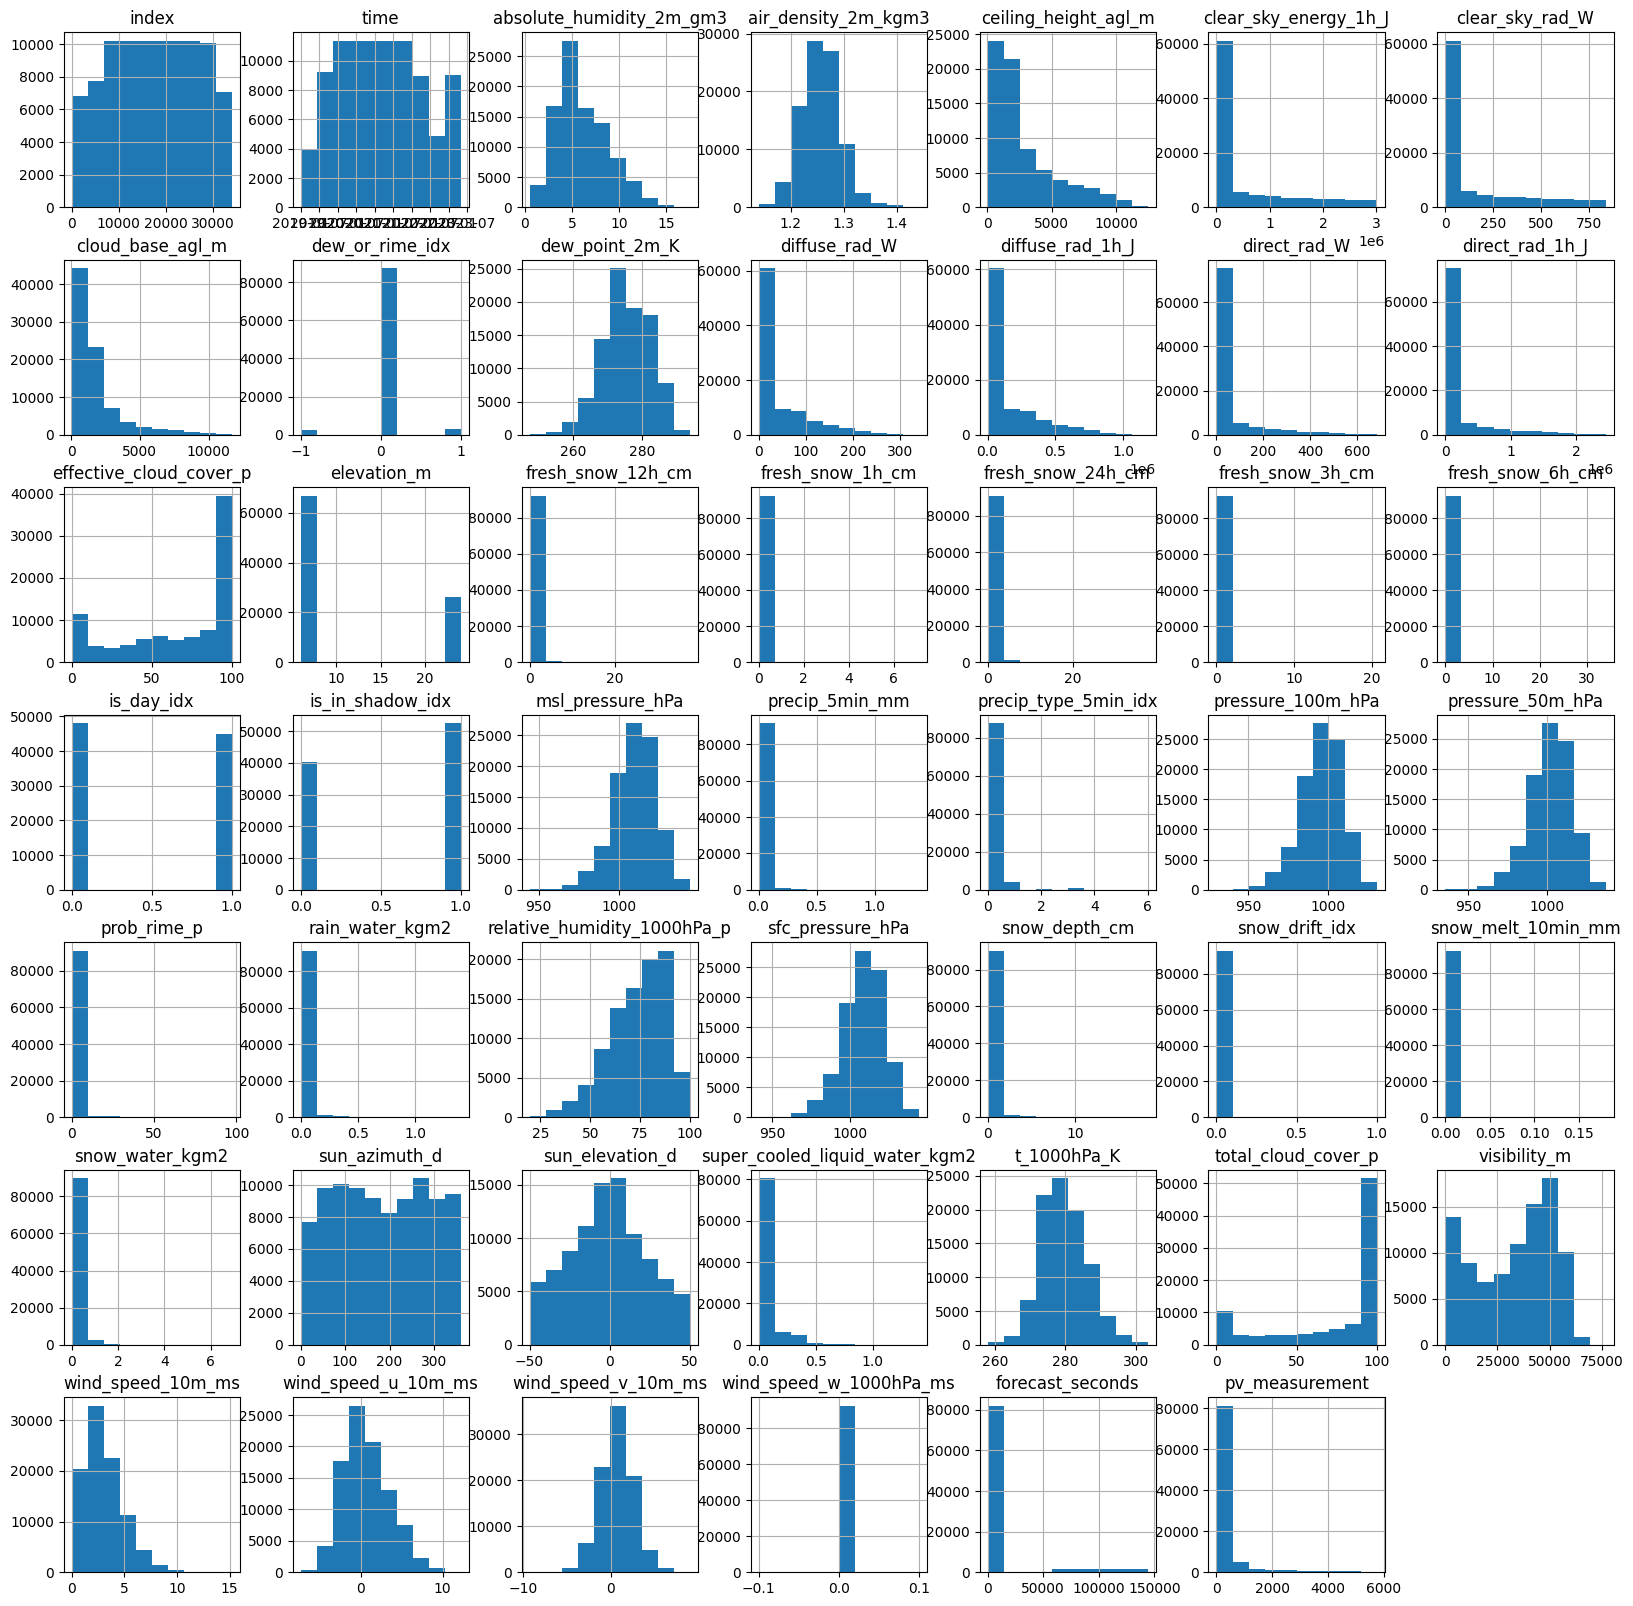

In [12]:
train_data.hist(figsize=(20,20));

1. index
2. time
3. absolute_humidity_2m_gm3
4. air_density_2m_kgm3
5. ceiling_height_agl_m
6. clear_sky_energy_1h_J
7. clear_sky_rad_W
8. cloud_base_agl_m
9. dew_or_rime_idx
10. dew_point_2m_K
11. diffuse_rad_W
12. diffuse_rad_1h_J
13. direct_rad_W
14. direct_rad_1h_J
15. effective_cloud_cover_p
16. elevation_m
17. fresh_snow_12h_cm
18. fresh_snow_1h_cm
19. fresh_snow_24h_cm
20. fresh_snow_3h_cm
21. fresh_snow_6h_cm
22. is_day_idx
23. is_in_shadow_idx
24. msl_pressure_hPa
25. precip_5min_mm
26. precip_type_5min_idx
27. pressure_100m_hPa
28. pressure_50m_hPa
29. prob_rime_p
30. rain_water_kgm2
31. relative_humidity_1000hPa_p
32. sfc_pressure_hPa
33. snow_depth_cm
34. snow_drift_idx
35. snow_melt_10min_mm
36. snow_water_kgm2
37. sun_azimuth_d
38. sun_elevation_d
39. super_cooled_liquid_water_kgm2
40. t_1000hPa_K
41. total_cloud_cover_p
42. visibility_m
43. wind_speed_10m_ms
44. wind_speed_u_10m_ms
45. wind_speed_v_10m_ms
46. wind_speed_w_1000hPa_ms
47. forecast_seconds
48. location
49. 

C:\Users\clar1\AppData\Local\Temp\ipykernel_14124\3528957958.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(train_data.corr(), cmap="PRGn", interpolation="none", vmin=-1, vmax=1)


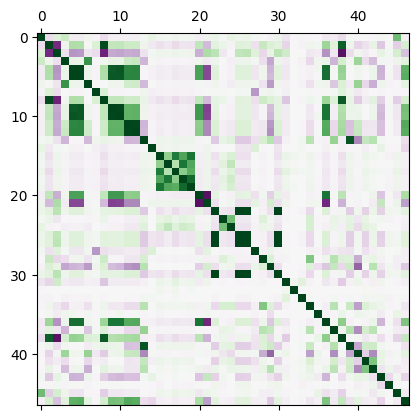

In [13]:
for i, column in enumerate(train_data.columns, 1):
    print(f"{i}. {column}")

plt.matshow(train_data.corr(), cmap="PRGn", interpolation="none", vmin=-1, vmax=1)
plt.show()

## Setup pycaret

In [15]:
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()
n_select = 5 # Select the top n models
turbo = True # Filter away slow models

## Simple model

### Simple data preprocceing

In [14]:
exp.setup(
    train_data, 
    target = 'pv_measurement', 
    create_date_columns = ['hour', 'day', 'month', 'year'],
    normalize = True,
    #pca = True,
    #pca_components = 'mle',
    #polynomial_features = True,
    #remove_multicollinearity = True,
    #imputation_type = 'iterative',
    #numeric_iterative_imputer = 'et',
    #feature_selection = True, 
)

### Compare models

In [15]:
simple_top_models = exp.compare_models(sort='MAE', turbo=turbo, n_select=n_select)

### Simple best model

Choose best model

In [16]:
simple_best_model = simple_top_models[0]

Visualize model

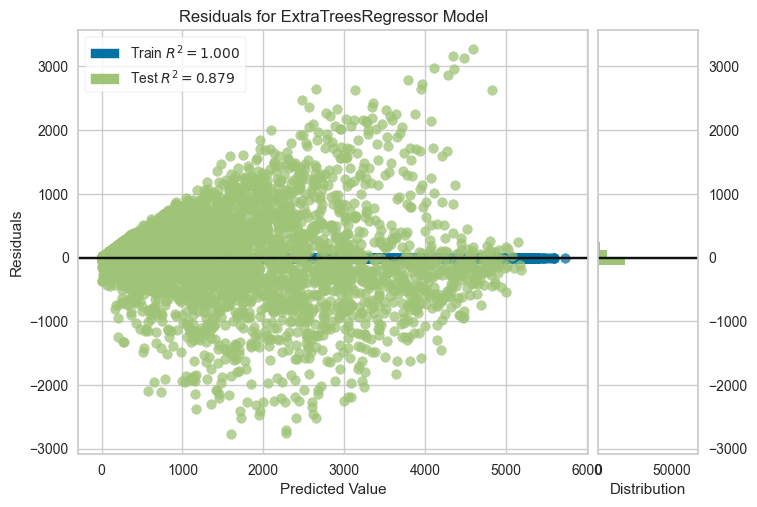

In [17]:
exp.plot_model(simple_best_model, plot='residuals')

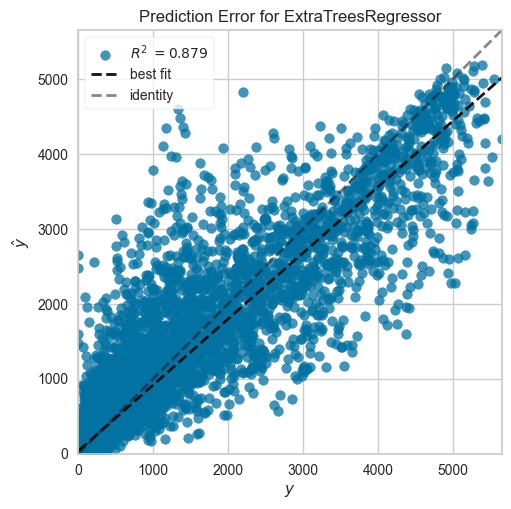

In [18]:
exp.plot_model(simple_best_model, plot='error')

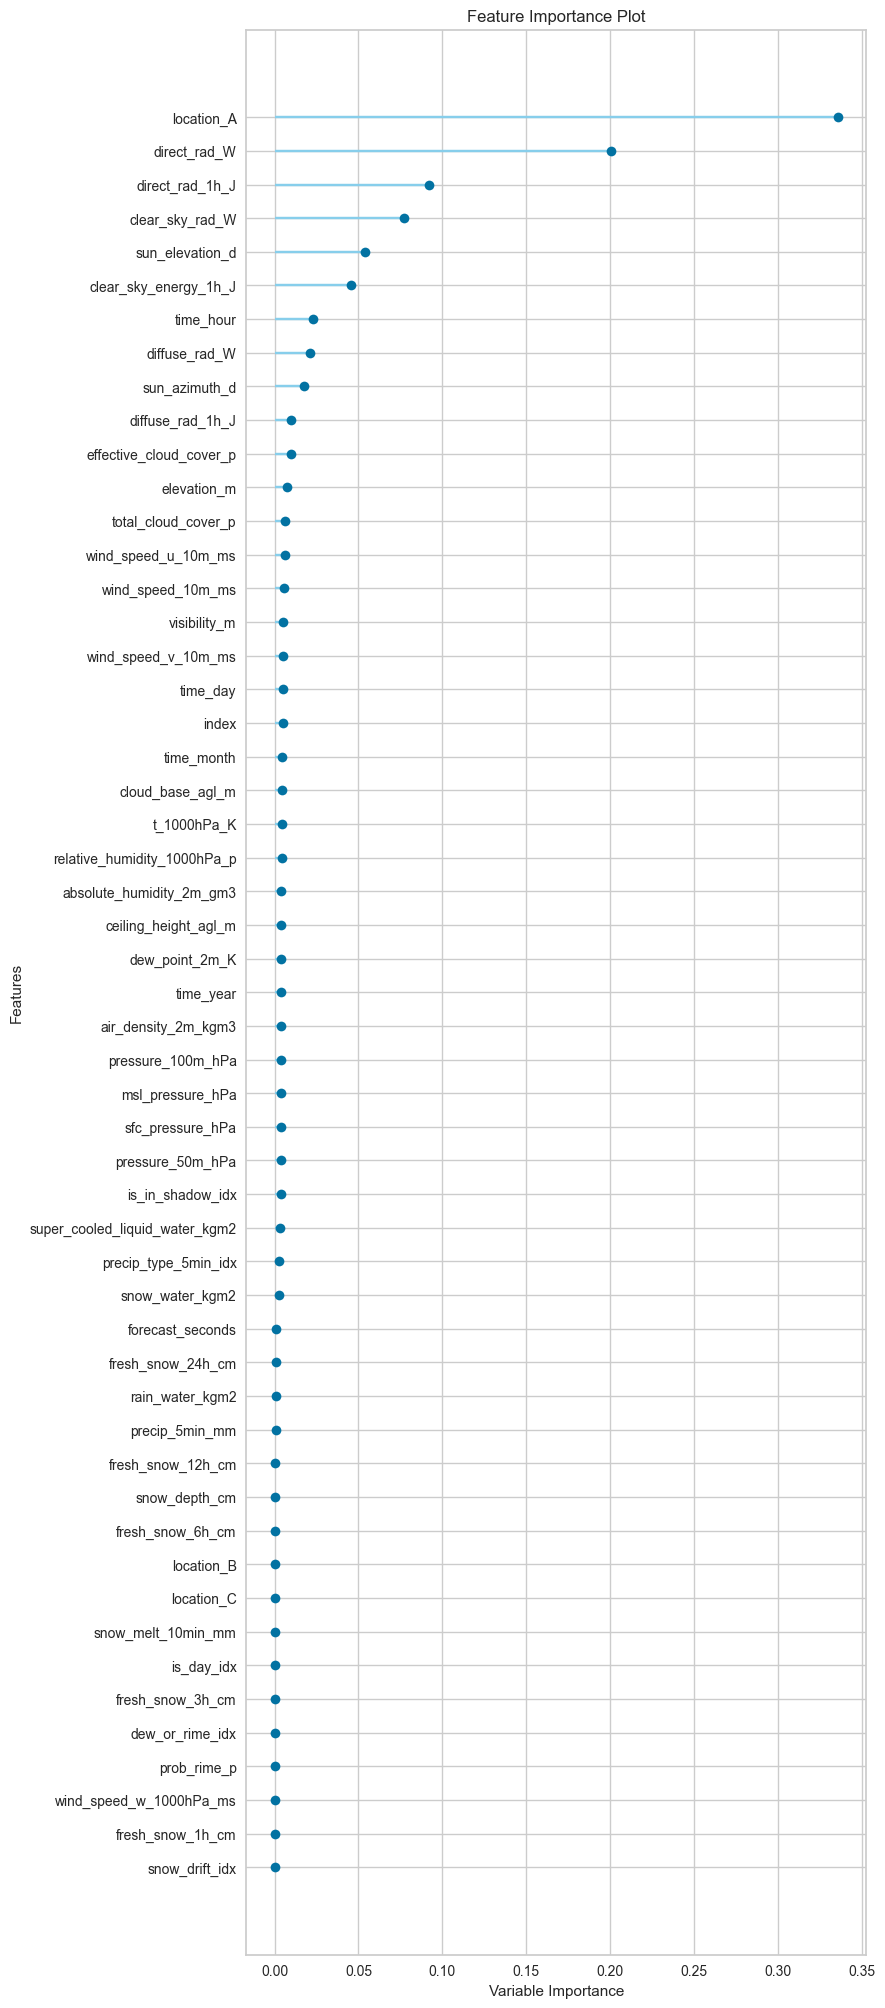

In [19]:
exp.plot_model(simple_best_model, plot='feature_all')

Tune model

In [20]:
#simple_best_model = exp.tune_model(simple_best_model, optimize='MAE', search_library='scikit-optimize')

Finalize model

In [21]:
simple_best_model = exp.finalize_model(simple_best_model)

Save model

In [22]:
exp.save_model(simple_best_model, 'simple_best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                   'day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['index',
                                              'absolute_humidity_2m_gm3',
                                              'air_density_2m_kgm3',
                                              'ceiling_height_agl_m',
                                              'clear_sky_energy_1h_J',
                                              'clear_sky_r...
                  TransformerWrapper(include=['locati

### Simple blended model

Blend top models

In [23]:
simple_blended_model = exp.blend_models(simple_top_models)

Visualize model

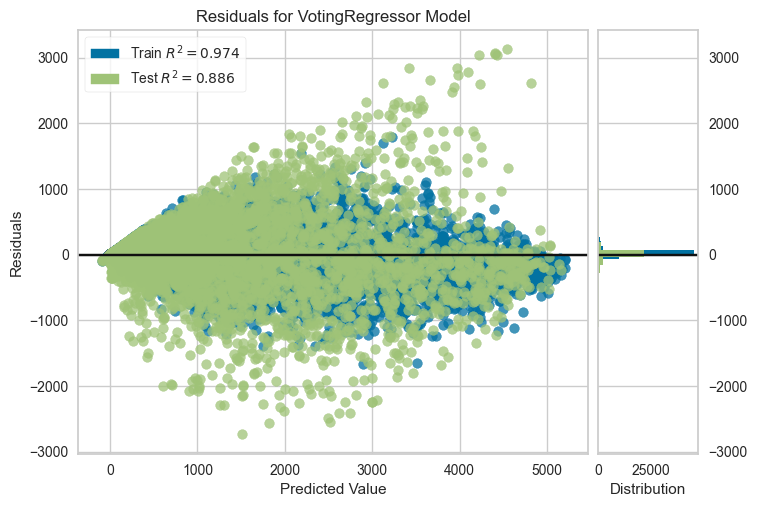

In [24]:
exp.plot_model(simple_blended_model, plot='residuals')

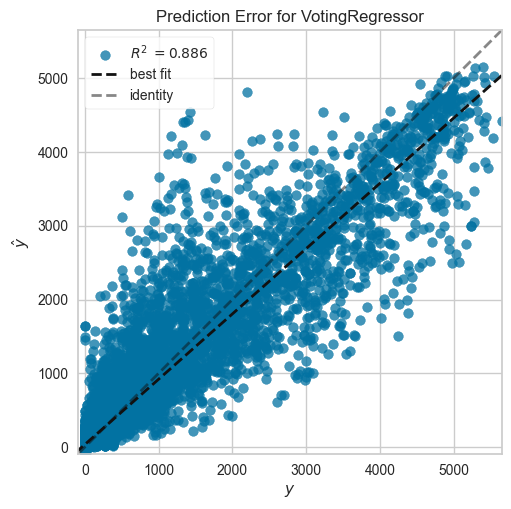

In [25]:
exp.plot_model(simple_blended_model, plot='error')

In [26]:
#exp.plot_model(simple_blended_model, plot='feature_all')

Tune model

In [27]:
#simple_blended_model = exp.tune_model(simple_blended_model, optimize='MAE', search_library='scikit-optimize')

Finalize model

In [28]:
simple_blended_model = exp.finalize_model(simple_blended_model)

Save model

In [29]:
exp.save_model(simple_blended_model, 'simple_blended_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                   'day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['index',
                                              'absolute_humidity_2m_gm3',
                                              'air_density_2m_kgm3',
                                              'ceiling_height_agl_m',
                                              'clear_sky_energy_1h_J',
                                              'clear_sky_r...
                                                     

### Simple stacked model

Stack top models

In [30]:
simple_stacked_model = exp.stack_models(simple_top_models)

Visualize model

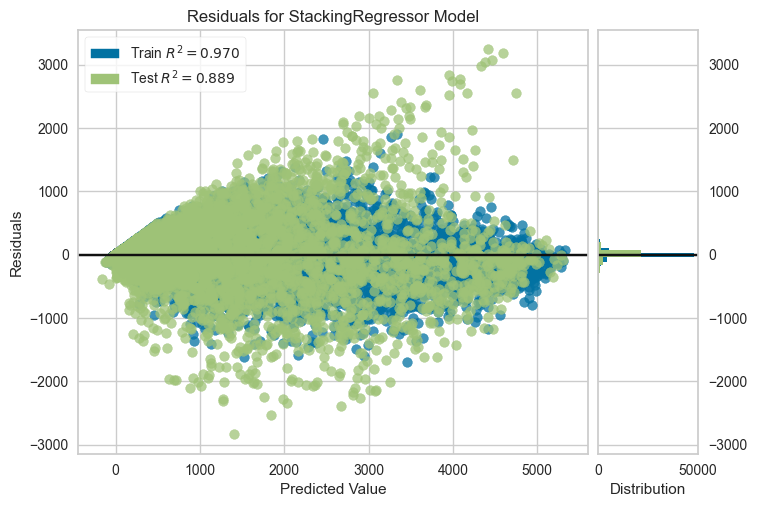

In [31]:
exp.plot_model(simple_stacked_model, plot='residuals')

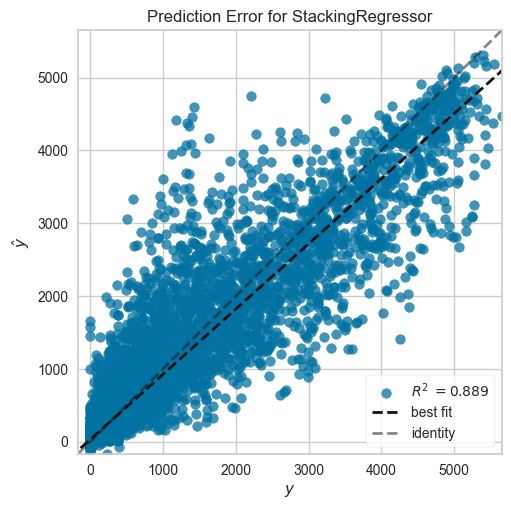

In [32]:
exp.plot_model(simple_stacked_model, plot='error')

In [33]:
#exp.plot_model(simple_stacked_model, plot='feature_all')

Tune model

In [34]:
#simple_stacked_model = exp.tune_model(simple_stacked_model, optimize='MAE', search_library='scikit-optimize')

Finalize model

In [35]:
simple_stacked_model = exp.finalize_model(simple_stacked_model)

Save model

In [36]:
exp.save_model(simple_stacked_model, 'simple_stacked_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                   'day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['index',
                                              'absolute_humidity_2m_gm3',
                                              'air_density_2m_kgm3',
                                              'ceiling_height_agl_m',
                                              'clear_sky_energy_1h_J',
                                              'clear_sky_r...
                                                     

## Advanced model

### Advanced data preprocceing

In [16]:
exp.setup(
    train_data, 
    target = 'pv_measurement', 
    create_date_columns = ['hour', 'day', 'month', 'year'],
    normalize = True,
    pca = True,
    pca_components = 'mle',
    polynomial_features = True,
    remove_multicollinearity = True,
    #imputation_type = 'iterative',
    #numeric_iterative_imputer = 'et',
    #feature_selection = True, 
)

### Compare models

In [17]:
advanced_top_models = exp.compare_models(sort='MAE', turbo=turbo, n_select=n_select)

### Advanced best model

Choose best model

In [18]:
advanced_best_model = advanced_top_models[0]

Visualize model

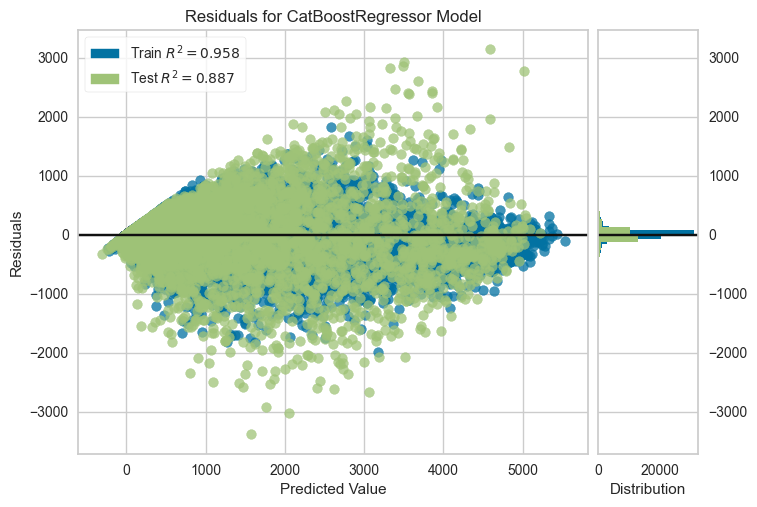

In [19]:
exp.plot_model(advanced_best_model, plot='residuals')

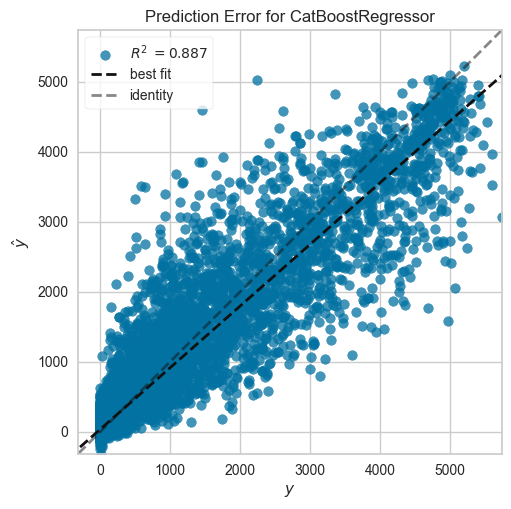

In [20]:
exp.plot_model(advanced_best_model, plot='error')

In [36]:
#exp.plot_model(advanced_best_model, plot='feature')

Tune model

In [22]:
#advanced_best_model = exp.tune_model(advanced_best_model, optimize='MAE', search_library='scikit-optimize')

Finalize model

In [23]:
advanced_best_model = exp.finalize_model(advanced_best_model)

Save model

In [24]:
exp.save_model(advanced_best_model, 'advanced_best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                   'day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['index',
                                              'absolute_humidity_2m_gm3',
                                              'air_density_2m_kgm3',
                                              'ceiling_height_agl_m',
                                              'clear_sky_energy_1h_J',
                                              'clear_sky_r...
                  TransformerWrapper(transformer=Poly

### Advanced blended model

Blend top models

In [25]:
advanced_blended_model = exp.blend_models(advanced_top_models)

Visualize model

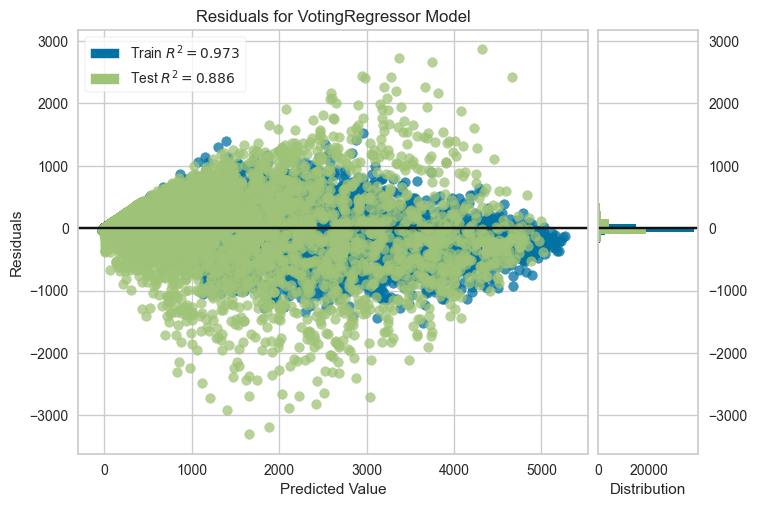

In [26]:
exp.plot_model(advanced_blended_model, plot='residuals')

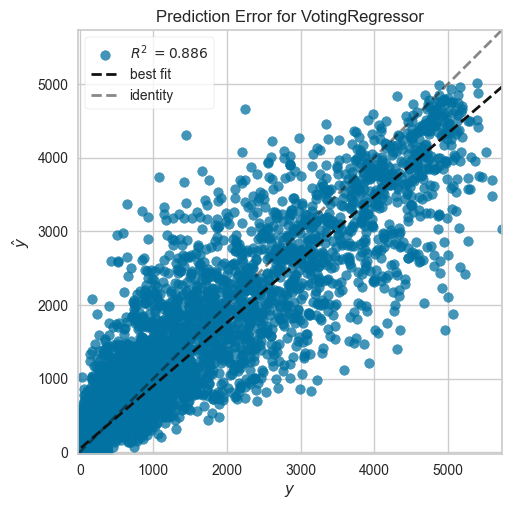

In [27]:
exp.plot_model(advanced_blended_model, plot='error')

In [28]:
#exp.plot_model(advanced_blended_model, plot='feature_all')

Tune model

In [29]:
#advanced_blended_model = exp.tune_model(advanced_blended_model, optimize='MAE', search_library='scikit-optimize')

Finalize model

In [30]:
advanced_blended_model = exp.finalize_model(advanced_blended_model)

Save model

In [31]:
exp.save_model(advanced_blended_model, 'advanced_blended_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                   'day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['index',
                                              'absolute_humidity_2m_gm3',
                                              'air_density_2m_kgm3',
                                              'ceiling_height_agl_m',
                                              'clear_sky_energy_1h_J',
                                              'clear_sky_r...
                                               <catbo

### Advanced stacked model (skipped too slow)

Stack top models

In [33]:
#advanced_stacked_model = exp.stack_models(advanced_top_models)

Visualize model

In [ ]:
#exp.plot_model(advanced_stacked_model, plot='residuals')

In [ ]:
#exp.plot_model(advanced_stacked_model, plot='error')

In [ ]:
#exp.plot_model(advanced_stacked_model, plot='feature_all')

Tune model

In [ ]:
#advanced_stacked_model = exp.tune_model(advanced_stacked_model, optimize='MAE', search_library='scikit-optimize')

Finalize model

In [ ]:
#advanced_stacked_model = exp.finalize_model(advanced_stacked_model)

Save model

In [ ]:
#exp.save_model(advanced_stacked_model, 'advanced_stacked_model')

## Load models

In [39]:
simple_best_model = exp.load_model("simple_best_model")

Transformation Pipeline and Model Successfully Loaded


In [40]:
simple_blended_model = exp.load_model("simple_blended_model")

Transformation Pipeline and Model Successfully Loaded


In [46]:
simple_stacked_model = exp.load_model("simple_stacked_model")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
advanced_best_model = exp.load_model("advanced_best_model")

In [ ]:
advanced_blended_model = exp.load_model("advanced_blended_model")

## Predictions

Make predictions

In [186]:
simple_best_predictions_data = exp.predict_model(simple_best_model, data=test_data)

In [187]:
simple_blended_predictions_data = exp.predict_model(simple_blended_model, data=test_data)

In [188]:
simple_stacked_predictions_data = exp.predict_model(simple_stacked_model, data=test_data)

In [189]:
advanced_best_predictions_data = exp.predict_model(advanced_best_model, data=test_data)

In [190]:
advanced_blended_predictions_data = exp.predict_model(advanced_blended_model, data=test_data)

Filter away non-whole hours

In [191]:
simple_best_predictions_data = simple_best_predictions_data[simple_best_predictions_data["time"].dt.minute == 0]

In [192]:
simple_blended_predictions_data = simple_blended_predictions_data[simple_blended_predictions_data["time"].dt.minute == 0]

In [193]:
simple_stacked_predictions_data = simple_stacked_predictions_data[simple_stacked_predictions_data["time"].dt.minute == 0]

In [194]:
advanced_best_predictions_data = advanced_best_predictions_data[advanced_best_predictions_data["time"].dt.minute == 0]

In [195]:
advanced_blended_predictions_data = advanced_blended_predictions_data[advanced_blended_predictions_data["time"].dt.minute == 0]

Convert to series and set negative values to 0

In [196]:
simple_best_predictions = simple_best_predictions_data["prediction_label"].apply(lambda x: max(x, 0)).reset_index(drop=True)

In [197]:
simple_blended_predictions = simple_blended_predictions_data["prediction_label"].apply(lambda x: max(x, 0)).reset_index(drop=True)

In [198]:
simple_stacked_predictions = simple_stacked_predictions_data["prediction_label"].apply(lambda x: max(x, 0)).reset_index(drop=True)

In [199]:
advanced_best_predictions = advanced_best_predictions_data["prediction_label"].apply(lambda x: max(x, 0)).reset_index(drop=True)

In [200]:
advanced_blended_predictions = advanced_blended_predictions_data["prediction_label"].apply(lambda x: max(x, 0)).reset_index(drop=True)

### View predictions

<Axes: >

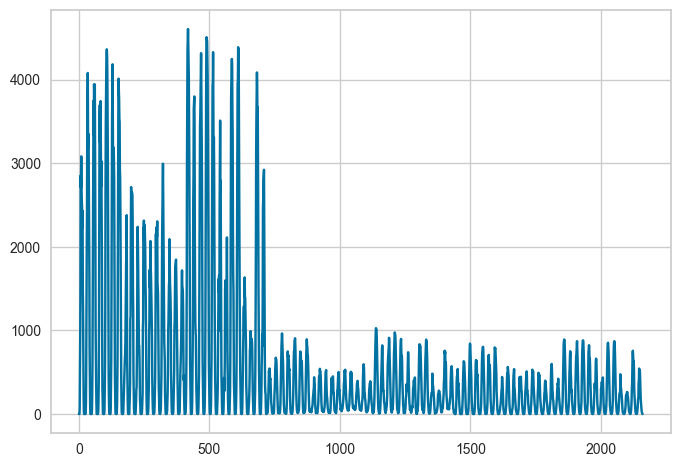

In [201]:
simple_best_predictions.plot()

In [202]:
simple_best_predictions.describe()

count    2160.000000
mean      567.353786
std       909.532235
min         0.000000
25%        33.702187
50%       225.002138
75%       616.582962
max      4604.327170
Name: prediction_label, dtype: float64

<Axes: >

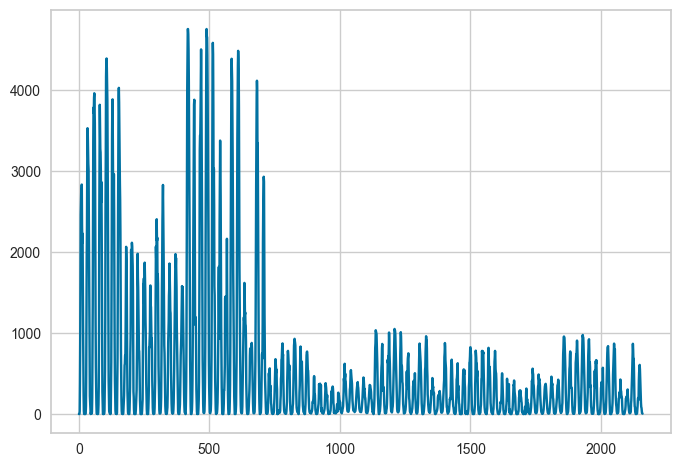

In [203]:
simple_blended_predictions.plot()

In [204]:
simple_blended_predictions.describe()

count    2160.000000
mean      548.443301
std       894.794644
min         0.000000
25%        26.839650
50%       202.920984
75%       623.539915
max      4755.309394
Name: prediction_label, dtype: float64

<Axes: >

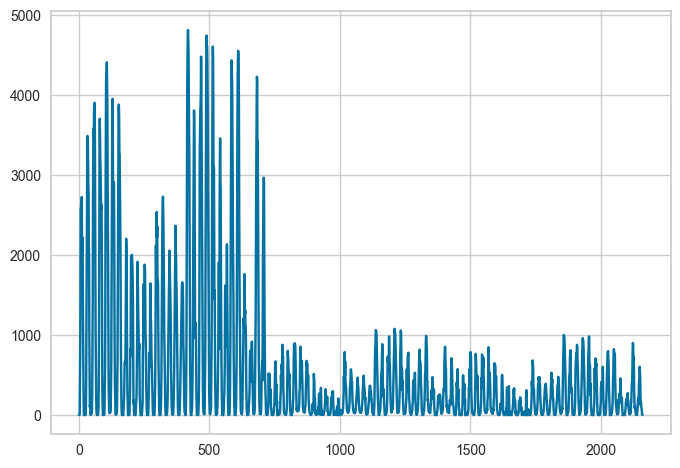

In [205]:
simple_stacked_predictions.plot()

In [206]:
simple_stacked_predictions.describe()

count    2160.000000
mean      536.103605
std       897.235988
min         0.000000
25%        27.408543
50%       173.938273
75%       603.118187
max      4816.776327
Name: prediction_label, dtype: float64

<Axes: >

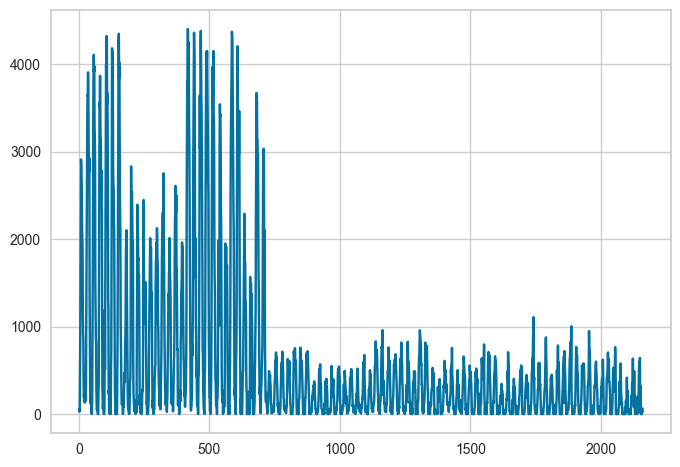

In [207]:
advanced_best_predictions.plot()

In [208]:
advanced_best_predictions.describe()

count    2160.000000
mean      582.632038
std       915.122116
min         0.000000
25%        50.272554
50%       232.663697
75%       580.458174
max      4403.229326
Name: prediction_label, dtype: float64

<Axes: >

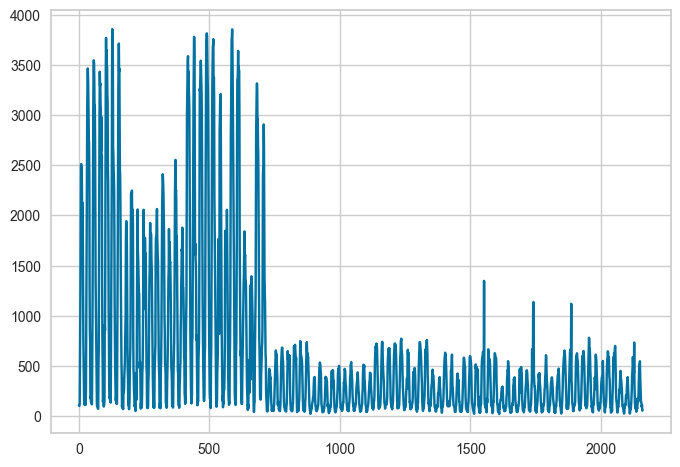

In [209]:
advanced_blended_predictions.plot()

In [210]:
advanced_blended_predictions.describe()

count    2160.000000
mean      617.363818
std       834.627952
min        18.383521
25%       110.253517
50%       312.032150
75%       618.738051
max      3860.056145
Name: prediction_label, dtype: float64

### Save predictions

In [211]:
ids = pd.Series(range(2160))

In [218]:
pd.DataFrame({"id": ids, "pv_measurement": simple_best_predictions}).describe()

id  pv_measurement
count  2160.000000     2160.000000
mean   1079.500000      567.353786
std     623.682612      909.532235
min       0.000000        0.000000
25%     539.750000       33.702187
50%    1079.500000      225.002138
75%    1619.250000      616.582962
max    2159.000000     4604.327170

In [219]:
pd.DataFrame({"id": ids, "pv_measurement": simple_best_predictions})

id  pv_measurement
0        0        0.000000
1        1        0.000000
2        2        0.580800
3        3       71.416401
4        4      437.212598
...    ...             ...
2155  2155       55.466242
2156  2156       26.615761
2157  2157       14.406000
2158  2158        2.156000
2159  2159        0.323400

[2160 rows x 2 columns]

In [213]:
pd.DataFrame({"id": ids, "pv_measurement": simple_best_predictions}).to_parquet(os.path.join("predictions", "simple_best_predictions.parquet"))

In [214]:
pd.DataFrame({"id": ids, "pv_measurement": simple_blended_predictions }).to_parquet(os.path.join("predictions", "simple_blended_predictions.parquet"))

In [215]:
pd.DataFrame({"id": ids, "pv_measurement": simple_stacked_predictions}).to_parquet(os.path.join("predictions", "simple_stacked_predictions.parquet"))

In [216]:
pd.DataFrame({"id": ids, "pv_measurement": advanced_best_predictions}).to_parquet(os.path.join("predictions", "advanced_best_predictions.parquet"))

In [217]:
pd.DataFrame({"id": ids, "pv_measurement": advanced_blended_predictions}).to_parquet(os.path.join("predictions", "advanced_blended_predictions.parquet"))